In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV1
from torch_geometric.data import DataLoader 
from model_SE import Net
from torch_geometric.nn import knn_graph

import numpy as np
import time
from Imports import Aggloremative, calculate_reco_to_sim_score, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
#1: Load Data + Model
#1.1: Load Data Through the dataloader - used for predictions
testpath = "/vols/cms/mm1221/Data/100k/5e/test/"  
data_test = CCV1(testpath, max_events=10000, inp = 'test')
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])



### Loading tracksters data


  0%|                                                     | 0/1 [00:00<?, ?it/s]

/vols/cms/mm1221/Data/100k/5e/test/raw/test.root


  0%|                                                     | 0/1 [00:17<?, ?it/s]

Reached 10000 events!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
print(data_test)

In [7]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/100k/5e/test/raw/test.root'
data_file = uproot.open(data_path)

ass = data_file['associations']['tsCLUE3D_recoToSim_CP'].array()

Track_ind = data_file['tracksters;1']['vertices_indexes'].array()
GT_ind = data_file['simtrackstersCP;3']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP;3']['vertices_multiplicity'].array()
GT_bc = data_file['simtrackstersCP;3']['barycenter_x'].array()
energies = data_file['clusters;3']['energy'].array()
LC_x = data_file['clusters;3']['position_x'].array()
LC_y = data_file['clusters;3']['position_y'].array()
LC_z = data_file['clusters;3']['position_z'].array()
LC_eta = data_file['clusters;3']['position_eta'].array()
MT_ind = data_file['trackstersMerged;2']['vertices_indexes'].array()

#1.3 Filter so get rid of events with 0 calo particles
skim_mask = []
for e in GT_bc:
    if 1 <= len(e) <= 5:
        skim_mask.append(True)
    else:
        skim_mask.append(False)

Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
LC_x = LC_x[skim_mask]
LC_y = LC_y[skim_mask]
LC_z = LC_z[skim_mask]
LC_eta = LC_eta[skim_mask]
MT_ind = MT_ind[skim_mask]
ass = ass[skim_mask]






In [8]:
import awkward as ak

def filter_repeated_indexes(GT_ind, GT_mult):
    """
    Given:
       - GT_ind: an awkward array (or list of lists) of indexes for one event.
       - GT_mult: an awkward array (or list of lists) of multiplicity values (same shape as GT_ind).
    
    For any index that appears in more than one sub-array, keep only the occurrence with the
    smallest multiplicity, and set that multiplicity to 1.0. All other occurrences are removed.
    
    Returns:
       new_GT_ind, new_GT_mult  
         Both are returned as <class 'awkward.highlevel.Array'>.
    """
    # 1. Record all occurrences of each index.
    occurrences = {}
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            occurrences.setdefault(val, []).append((sub_i, pos, mult))
    
    # 2. Mark occurrences to remove and those to update.
    removals = set()
    update_to_one = set()
    
    for index_val, occ_list in occurrences.items():
        if len(occ_list) > 1:
            occ_list_sorted = sorted(occ_list, key=lambda x: x[2])  # Sort by multiplicity
            kept_occ = occ_list_sorted[0]  # Keep lowest multiplicity
            update_to_one.add((kept_occ[0], kept_occ[1]))
            for occ in occ_list_sorted[1:]:
                removals.add((occ[0], occ[1]))
    
    # 3. Reconstruct new GT_ind and GT_mult by filtering out the removals.
    new_GT_ind = []
    new_GT_mult = []
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        new_sub_ind = []
        new_sub_mult = []
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            if (sub_i, pos) in removals:
                continue
            new_sub_ind.append(val)
            new_sub_mult.append(1.0 if (sub_i, pos) in update_to_one else mult)
        new_GT_ind.append(new_sub_ind)
        new_GT_mult.append(new_sub_mult)
    
    # Convert lists to awkward arrays
    return ak.Array(new_GT_ind), ak.Array(new_GT_mult)

def filter_repeated_indexes_for_events(all_GT_ind, all_GT_mult):
    """
    Given a list of events, each with its GT_ind and GT_mult (lists of sub-arrays),
    apply filter_repeated_indexes to each event.
    
    Args:
        all_GT_ind: List of events. Each event is an awkward array (or list of sub-arrays) of indexes.
        all_GT_mult: List of events. Each event is an awkward array (or list of sub-arrays) of multiplicity values.
    
    Returns:
        new_all_GT_ind, new_all_GT_mult: Awkward arrays (one per event) of filtered GT_ind and GT_mult.
    """
    new_all_GT_ind = []
    new_all_GT_mult = []
    
    # Loop over each event
    for event_ind, event_mult in zip(all_GT_ind, all_GT_mult):
        new_event_ind, new_event_mult = filter_repeated_indexes(event_ind, event_mult)
        new_all_GT_ind.append(new_event_ind)
        new_all_GT_mult.append(new_event_mult)
    
    # Convert to awkward arrays
    return ak.Array(new_all_GT_ind), ak.Array(new_all_GT_mult)


In [9]:
GT_ind, GT_mult = filter_repeated_indexes_for_events(GT_ind, GT_mult)

KeyboardInterrupt: 

In [ ]:
for item in GT_ind[2][0]:
    print(item, end=", ")
print('....')
print(len(GT_ind[2][0]))
print(len(GT_ind2[0][0]))
print(GT_ind2[0][0])

In [3]:
# load the model 
model = Net(
    hidden_dim=128,
    num_layers=4,
    dropout=0.3,
    contrastive_dim=16
)
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/Track/NegativeMining/resultslr5t54SECEXT/best_model.pt',  map_location=torch.device('cpu'))
checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/Track/Negative/resultsSECNeg/best_model.pt',  map_location=torch.device('cpu'))

model.load_state_dict(checkpoint)  
model.eval()  

Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-3): 4 x CustomStaticEdgeConv(
      (nn_module): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): ELU(alpha=1.0)
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)

In [7]:
import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(Track_ind):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)


In [8]:

#3: Make Predictions + Cluster -> Calculate the inference time
#3.1: Make Predictions

all_predictions = []  
total_times = []
start_time = time.time()

for i, data in enumerate(data_test):
    edge_index = knn_graph(data.x, k=16)  
    predictions = model(data.x, edge_index, 1)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

#3.2: Cluster using threshold found in Script A

all_cluster_labels = Aggloremative(all_predictions, threshold = 0.18)

end_time = time.time()

#3.3: Calculate average inference time

time_diff = end_time - start_time
inference_time = time_diff/len(all_cluster_labels)
print("average inference time:", inference_time)



average inference time: 0.007206777763366699


Processing events: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:25<00:00, 117.87it/s]


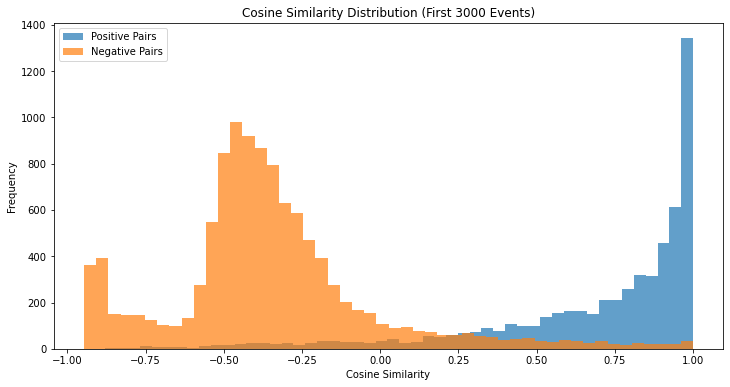

In [61]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute cosine similarities from a set of edge indices.
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    """
    Given embeddings (tensor of shape [N, D]) and edge_indices (tensor of shape [num_edges, 2]),
    compute the cosine similarity for each edge.
    If skip_self is True, edges where source==target are skipped.
    Returns a NumPy array of similarities.
    """
    sims = []
    for edge in edge_indices:
        src, tgt = edge.tolist()
        if skip_self and src == tgt:
            continue
        # Cosine similarity for unit-norm embeddings is just their dot product.
        sim = F.cosine_similarity(embeddings[src].unsqueeze(0), embeddings[tgt].unsqueeze(0))
        sims.append(sim.item())
    return np.array(sims)

# Assuming:
# - all_predictions is a list (length >= 1000) of NumPy arrays,
#   where each element is an array of embeddings for one event.
# - data_test is a list (length >= 1000) of data objects with attributes x_pe and x_ne
#   (each as tensors of shape [num_nodes, 2]) that give the positive and negative edge indices.
# If you do not already have normalized embeddings in all_predictions, we will normalize them.

num_events = 300
all_pos_sims = []
all_neg_sims = []

# Loop over the first 1000 events.
for i in tqdm(range(num_events), desc="Processing events"):
    # Convert predictions for event i to a tensor and normalize them.
    pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)
    pred_norm = F.normalize(pred_tensor, p=2, dim=1)

    # Compute cosine similarities for positive and negative edges.
    pos_sims = compute_cosine_similarities(pred_norm, data_test[i].x_pe, skip_self=True)
    neg_sims = compute_cosine_similarities(pred_norm, data_test[i].x_ne, skip_self=True)
    
    all_pos_sims.extend(pos_sims.tolist())
    all_neg_sims.extend(neg_sims.tolist())

all_pos_sims = np.array(all_pos_sims)
all_neg_sims = np.array(all_neg_sims)

# Plot histograms for positive and negative cosine similarities.
plt.figure(figsize=(12, 6))
plt.hist(all_pos_sims, bins=50, alpha=0.7, label="Positive Pairs")
plt.hist(all_neg_sims, bins=50, alpha=0.7, label="Negative Pairs")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution (First 3000 Events)")
plt.legend()
plt.savefig("plots/final.png")
plt.show()


In [9]:
import os
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.nn import knn_graph

# Define the cosine similarity function
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    sims = []
    for edge in edge_indices:
        src, tgt = edge.tolist()
        if skip_self and src == tgt:
            continue
        sim = F.cosine_similarity(embeddings[src].unsqueeze(0),
                                  embeddings[tgt].unsqueeze(0))
        sims.append(sim.item())
    return np.array(sims)

# Function to parse hyperparameters from the folder name.
# For example: "results_lr0.001_bs64_hd128_nl3_temp0.05_cd128_k24"
# will extract hidden_dim=128, num_layers=3, contrastive_dim=128.
def parse_hyperparams(folder_name):
    tokens = folder_name.split("_")
    hidden_dim = None
    num_layers = None
    contrastive_dim = None
    for token in tokens:
        if token.startswith("hd"):
            hidden_dim = int(token[2:])
        elif token.startswith("nl"):
            num_layers = int(token[2:])
        elif token.startswith("cd"):
            contrastive_dim = int(token[2:])
    return hidden_dim, num_layers, contrastive_dim

# Define your model architecture (adjust as needed)
class Net(torch.nn.Module):
    def __init__(self, hidden_dim, num_layers, dropout, contrastive_dim):
        super(Net, self).__init__()
        # This is a placeholder; replace with your actual layers.
        self.fc = torch.nn.Linear(hidden_dim, contrastive_dim)
        self.num_layers = num_layers
        self.dropout = dropout
    
    def forward(self, x, edge_index, dummy_param):
        # Replace with your actual forward pass logic.
        return (self.fc(x),)

# List of folders containing the best_model.pt checkpoints
folders = [
    "results_lr0.001_bs64_hd128_nl3_temp0.05_cd128_k24",
    "results_lr0.001_bs64_hd128_nl3_temp0.05_cd128_k48",
    "results_lr0.001_bs64_hd128_nl3_temp0.05_cd128_k8",
    "results_lr0.001_bs64_hd128_nl3_temp0.05_cd8_k24",
    "results_lr0.001_bs64_hd128_nl3_temp0.05_cd8_k48",
    "results_lr0.001_bs64_hd128_nl3_temp0.05_cd8_k8"
]

# Base path to the directory containing your result folders
base_path = "/vols/cms/mm1221/hgcal/elec5New/Track/Hyperparam/results/"

# Define the number of test events to process (adjust as needed)
num_events = 300

# Dictionary to store mean similarities for each model
mean_sims = {}

# Loop over each folder/model
for folder in folders:
    checkpoint_path = os.path.join(base_path, folder, "best_model.pt")

    # Extract hyperparameters from the folder name.
    hidden_dim, num_layers, contrastive_dim = parse_hyperparams(folder)
    dropout2 = 0.3  # or parse if available
    # Initialize the model using parsed hyperparameters.
    model = Net(hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout2, contrastive_dim=contrastive_dim)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint, strict=False)
    model.eval()
    
    all_pos_sims = []
    all_neg_sims = []
    
    # Loop over a subset of test events.
    for i in tqdm(range(num_events), desc=f"Processing {folder}"):
        data = data_test[i]  # Assumes each element has attributes: x, x_pe, x_ne
        
        # Build the edge_index (adjust k as needed)
        edge_index = knn_graph(data.x, k=16)
        print(data.x)
        predictions = model(data.x, edge_index, 1)
        
        # Get and normalize the embeddings
        pred_tensor = torch.tensor(predictions[0].detach().cpu().numpy(), dtype=torch.float32)
        pred_norm = F.normalize(pred_tensor, p=2, dim=1)
        
        # Compute cosine similarities for positive and negative edges
        pos_sims = compute_cosine_similarities(pred_norm, data.x_pe, skip_self=True)
        neg_sims = compute_cosine_similarities(pred_norm, data.x_ne, skip_self=True)
        
        all_pos_sims.extend(pos_sims.tolist())
        all_neg_sims.extend(neg_sims.tolist())
    
    # Calculate mean similarities for the current model
    mean_pos = np.mean(all_pos_sims)
    mean_neg = np.mean(all_neg_sims)
    mean_sims[folder] = (mean_pos, mean_neg)

# Prepare data for plotting
folders_labels = list(mean_sims.keys())
mean_pos_values = [mean_sims[folder][0] for folder in folders_labels]
mean_neg_values = [mean_sims[folder][1] for folder in folders_labels]

x = np.arange(len(folders_labels))
width = 0.35

# Plot the mean positive and negative similarities as a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, mean_pos_values, width, label='Mean Positive Similarity')
ax.bar(x + width/2, mean_neg_values, width, label='Mean Negative Similarity')

ax.set_ylabel('Cosine Similarity')
ax.set_title('Mean Cosine Similarities for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(folders_labels, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


Processing results_lr0.001_bs64_hd128_nl3_temp0.05_cd128_k24:   0%| | 0/300 [00:

tensor([[ 9.4201e+01,  3.4228e+01,  3.3079e+02,  7.0849e+00,  1.9094e+00,
          3.4852e-01,  1.8074e+01,  1.3341e-01,  3.8402e-02,  2.7117e-01,
          1.0421e-01,  9.5688e-01,  3.9588e+00,  1.5167e+00,  5.2293e-01,
          2.0582e+00],
        [ 1.0612e+02,  2.5856e+01,  3.3487e+02,  1.7586e+02,  1.8391e+00,
          2.3899e-01,  4.2006e+01,  5.2121e-02,  1.7357e-02,  2.9832e-01,
          6.9600e-02,  9.5192e-01,  5.2654e+00,  8.7411e-01,  3.6860e+00,
          5.3871e+01],
        [ 9.7940e+01,  3.3770e+01,  3.3319e+02,  2.6877e+01,  1.8847e+00,
          3.3204e-01,  3.5167e+01,  1.7634e-01,  7.3811e-02,  2.8888e-01,
          9.5113e-02,  9.5263e-01,  5.0295e+00,  2.2037e+00,  2.2946e+00,
          8.1742e+00],
        [ 9.7806e+01,  3.4105e+01,  3.4082e+02,  2.9050e+00,  1.9065e+00,
          3.3552e-01,  3.8761e+00,  1.4803e+00,  2.8235e-03,  1.3443e-01,
         -1.2104e-01,  9.8350e-01,  1.9382e+00,  1.2643e+00,  6.4191e-02,
          5.2549e-01]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x16 and 128x128)

In [41]:
print(type(GT_ind[0][0]))
print(type(GT_ind2[0][0]))

<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>


In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar

def calculate_sim_to_reco_score(CaloParticle, energies_indices, ReconstructedTrackster, Multi):
    """
    Calculate the sim-to-reco score for a given CaloParticle and ReconstructedTrackster.
    
    Parameters:
    - CaloParticle: array of Layer Clusters in the CaloParticle.
    - Multiplicity: array of Multiplicity for layer clusters in CP
    - energies_indices: array of energies associated with all LC (indexed by LC).
    - ReconstructedTrackster: array of LC in the reconstructed Trackster.
    
    Returns:
    - sim_to_reco_score: the calculated sim-to-reco score.
    """
    numerator = 0.0
    denominator = 0.0

    energy_caloparticle_lc = energies_indices[CaloParticle] / Multi
    total_energy_caloparticle = sum(energy_caloparticle_lc)
    if total_energy_caloparticle == 0:
        return 1.0  # No energy in the CaloParticle implies perfect mismatch

    # Calculate total energy of the ReconstructedTrackster
    total_energy_trackster = sum(energies_indices[det_id] for det_id in ReconstructedTrackster)
    i = 0
    # Iterate over all DetIds in the CaloParticle
    for det_id in CaloParticle:
        energy_k = energies_indices[det_id]  # Energy for the current DetId in CaloParticle
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1 if det_id in ReconstructedTrackster else 0.0
        # Fraction of energy in the CaloParticle (fr_k^SC)
        fr_sc_k = 1 / Multi[i]

        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_sc_k ** 2                # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_sc_k ** 2) * (energy_k ** 2)
        i+=1

    # Calculate score
    sim_to_reco_score = numerator / denominator if denominator != 0 else 1.0
    return sim_to_reco_score

def calculate_reco_to_sim_score(ReconstructedTrackster, energies_indices, CaloParticle, Multi):
    """
    Calculate the reco-to-sim score for a given ReconstructedTrackster and CaloParticle.

    Parameters:
    - ReconstructedTrackster: array of DetIds in the ReconstructedTrackster.
    - energies_indices: array of energies associated with all DetIds (indexed by DetId).
    - CaloParticle: array of DetIds in the CaloParticle.

    Returns:
    - reco_to_sim_score: the calculated reco-to-sim score.
    """
    numerator = 0.0
    denominator = 0.0

    # Calculate total energy of the ReconstructedTrackster
    total_energy_trackster = sum(energies_indices[det_id] for det_id in ReconstructedTrackster)
    if total_energy_trackster == 0:
        return 1.0  # No energy in the Trackster implies perfect mismatch

    energy_caloparticle_lc = energies_indices[CaloParticle] / Multi
    total_energy_caloparticle = sum(energy_caloparticle_lc)
    # Iterate over all DetIds in the ReconstructedTrackster
    for det_id in ReconstructedTrackster:
        energy_k = energies_indices[det_id]  # Energy for the current DetId in the Trackster
        
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1

        #fr_sc_k = 1 if det_id in CaloParticle else 0.0
        if det_id in CaloParticle:
            index = np.where(CaloParticle == det_id)[0][0]  # Find the index
            Multiplicity = Multi[index]
            fr_sc_k = 1
        else:
            fr_sc_k = 0
            
        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_tst_k ** 2               # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_tst_k ** 2) * (energy_k ** 2)

    # Calculate score
    reco_to_sim_score = numerator / denominator if denominator != 0 else 1.0
    return reco_to_sim_score
def calculate_all_event_scores(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, multi, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in tqdm(range(num_events)):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_multi = multi[event_index]

        # Extract layer cluster positions and eta for this event
        event_x = np.array(LC_x[event_index])
        event_y = np.array(LC_y[event_index])
        event_z = np.array(LC_z[event_index])
        event_eta = np.array(LC_eta[event_index])

        # Compute barycenter for each CaloParticle
        cp_barycenters = []
        cp_avg_etas = []
        for caloparticle in caloparticles:
            # Compute barycenter (x, y, z)
            
            barycenter_x = np.mean([event_x[det_id] for det_id in caloparticle])
            barycenter_y = np.mean([event_y[det_id] for det_id in caloparticle])
            barycenter_z = np.mean([event_z[det_id] for det_id in caloparticle])
            cp_barycenters.append(np.array([barycenter_x, barycenter_y, barycenter_z]))
            
            # Compute average eta
            avg_eta = np.mean([event_eta[det_id] for det_id in caloparticle])
            cp_avg_etas.append(avg_eta)

        # Compute separation between two CaloParticles if at least two exist
        if len(cp_barycenters) >= 2:
            cp_separation = np.linalg.norm(cp_barycenters[0] - cp_barycenters[1])
        else:
            cp_separation = 0.0
            
        trackster_det_id_sets = [set(trackster) for trackster in tracksters]

        # Loop over all CaloParticles
        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            calo_det_ids = set(calo_id for calo_id in caloparticle)
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                trackster_det_ids = trackster_det_id_sets[trackster_idx]
                shared_det_ids = calo_det_ids.intersection(trackster_det_ids)
                
                # Calculate shared_energy by summing energies of shared det_ids
                shared_energy = np.sum(event_energies[list(shared_det_ids)]) if shared_det_ids else 0.0
                
                
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster, Calo_multi)
                # Calculate reco-to-sim score
                reco_to_sim_score = calculate_reco_to_sim_score(trackster, event_energies, caloparticle, Calo_multi)

                # Calculate total energy for CaloParticle and Trackster
                cp_energy_lc2 = event_energies[caloparticle] / Calo_multi
                cp_energy = np.sum(cp_energy_lc2)
                
                trackster_energy = np.sum([event_energies[det_id] for det_id in trackster])

                # Calculate energy difference ratio
                energy_diff_ratio = (trackster_energy / cp_energy if cp_energy != 0 else None)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "sim_to_reco_score": sim_to_reco_score,
                    "reco_to_sim_score": reco_to_sim_score,
                    "cp_energy": cp_energy,
                    "trackster_energy": trackster_energy,
                    "cp_avg_eta": cp_avg_etas[calo_idx],
                    "cp_separation": cp_separation,
                    "energy_ratio": energy_diff_ratio,
                    "shared_energy": shared_energy  # New column
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df



In [10]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):

    event_clusters = {} 
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].extend(Track_ind[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

#4.2 Make DF from our model and CERN


In [67]:
df_CL = calculate_all_event_scores(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, GT_mult, num_events = 1000)
df_TICL = calculate_all_event_scores(GT_ind, energies, MT_ind_filt, LC_x, LC_y, LC_z, LC_eta, GT_mult, num_events = 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.87it/s]


In [12]:
df_CL = pd.read_csv('df_scores_noRepeats.csv')
df_TICL = pd.read_csv('df_CERN_noRepeats.csv')

In [13]:
#5: Print metrics

def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to proess each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_energy'
    def is_cp_associated(group):
        cp_energy = group['cp_energy'].iloc[0]  # Assuming 'cp_energy' is consistent within the group
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
        # ----- Containment Calculation -----
    cp_valid_cont = df.dropna(subset=['cp_id']).copy()
    cp_grouped_cont = cp_valid_cont.groupby(['event_index', 'cp_id'])
    cp_associated_cont = cp_grouped_cont['sim_to_reco_score'].min() < 0.2
    num_associated_cp_cont = cp_associated_cont.sum()
    total_cp_cont = cp_associated_cont.count()
    containment = num_associated_cp_cont / total_cp_cont if total_cp_cont > 0 else 0


    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Containment: {containment:.4f} ({num_associated_cp_cont} associated CPs out of {total_cp_cont} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num tracksters ratio: {total_tst / total_cp if total_cp > 0 else 0:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity
    }

# Example usage
our_model_metrics = calculate_metrics(df_CL, "Our Model")
cern_model_metrics = calculate_metrics(df_TICL, "CERN Model")


Model: Our Model
Efficiency: 0.9806 (29352 associated CPs out of 29934 total CPs)
Containment: 0.9787 (29296 associated CPs out of 29934 total CPs)
Purity: 0.9652 (30136 associated Tracksters out of 31221 total Tracksters)
Num tracksters ratio: 1.0430

Model: CERN Model
Efficiency: 0.9752 (29098 associated CPs out of 29838 total CPs)
Containment: 0.9760 (29122 associated CPs out of 29838 total CPs)
Purity: 0.8561 (21363 associated Tracksters out of 24954 total Tracksters)
Num tracksters ratio: 0.8363


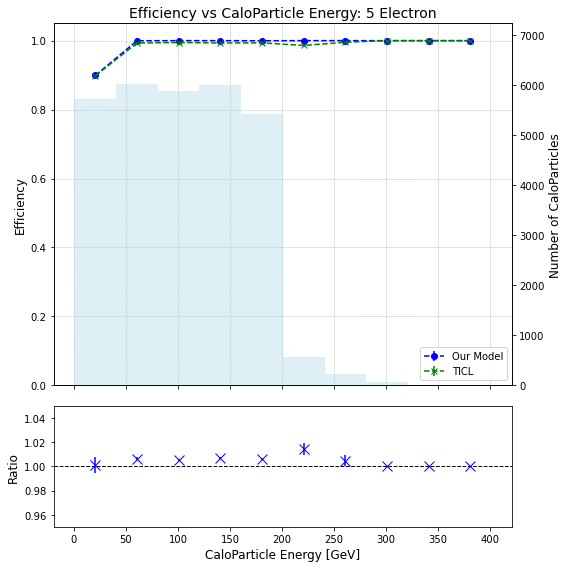

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_CL and df_TICL are your two DataFrames
# Replace the following with your actual data loading mechanism
# df_CL = pd.read_csv('df_CL.csv')
# df_TICL = pd.read_csv('df_TICL.csv')

# ----- Preprocessing -----
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')  # New Column
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_energy (they are identical).
      - Take the maximum shared_energy to check if any shared_energy >= 50% of cp_energy.
      - Mark the caloparticle as 'reconstructed' if any shared_energy >= 50% of cp_energy.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',          
        'shared_energy': 'max'        # Use max to determine if any shared_energy meets the threshold
    }).reset_index()
    
    # Mark as reconstructed if any shared_energy >= 50% of cp_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Prepare the caloparticle data for both DataFrames.
df_CL_cp = prepare_cp_data(df_CL)
df_TICL_cp = prepare_cp_data(df_TICL)

# ----- Bin Caloparticles by Energy -----
# Define energy bins based on the range of cp_energy from df_CL.
min_energy = df_CL_cp['cp_energy'].min()
max_energy = df_CL_cp['cp_energy'].max()
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ----- Calculate Efficiency per Energy Bin -----
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (number of reconstructed) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL = aggregate_efficiency(df_TICL_cp)

# ----- Plot Efficiency vs Energy with Histogram Overlay -----
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

eff_ratio = agg_CL['efficiency'] / agg_TICL['efficiency']
eff_ratio_error = eff_ratio * np.sqrt(
    (agg_CL['eff_error'] / agg_CL['efficiency'])**2 + 
    (agg_TICL['eff_error'] / agg_TICL['efficiency'])**2
)


# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)


# Plot Efficiency
ax1.errorbar(bin_centers, agg_CL['efficiency'], yerr=agg_CL['eff_error'], marker='o',linestyle ='--',  color='blue', label='Our Model')
ax1.errorbar(bin_centers, agg_TICL['efficiency'], yerr=agg_TICL['eff_error'],   marker='x', linestyle ='--', color='green', label='TICL')
ax1.set_ylabel('Efficiency', fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)



# ----- Histogram for Number of CaloParticles -----
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers, agg_CL['total_cp'], width=bar_width, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of CaloParticles', fontsize=12)
ax1_hist.set_ylim(0, agg_CL['total_cp'].max() * 1.2)

# ----- Ratio Plot -----
ax2.errorbar(bin_centers, eff_ratio, yerr=eff_ratio_error, fmt='x', color='blue', markersize=10)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('CaloParticle Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.95, 1.05)

# Update Title to Reflect New Efficiency Definition
plt.title(r'Efficiency vs CaloParticle Energy: 5 Electron', fontsize=14)
plt.tight_layout()
plt.savefig("plots/efficiency.png")
plt.show()


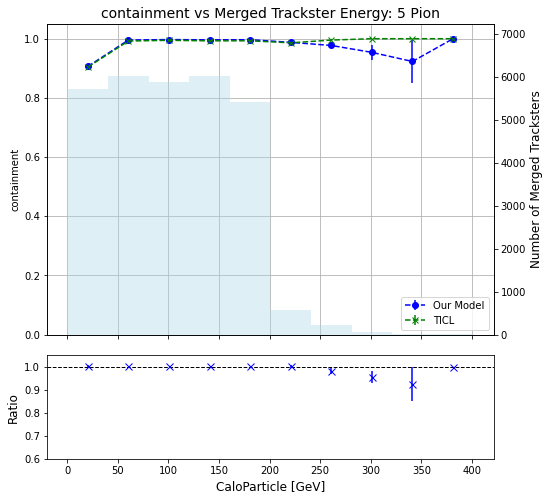

In [15]:

# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['sim_to_reco_score'] = pd.to_numeric(df['sim_to_reco_score'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for containment
# -----------------------------
def prepare_cont_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first cp_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',       # Use the first cp_energy value.
        'sim_to_reco_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['sim_to_reco_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_cont = prepare_cont_data(df_CL)
df_TICL_cont   = prepare_cont_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of cp_energy from df_CL.
min_energy_cont = df_CL_cont['cp_energy'].min()
max_energy_cont = df_CL_cont['cp_energy'].max()
n_bins_cont = 10  # Adjust the number of bins if desired.
energy_bins_cont = np.linspace(min_energy_cont, max_energy_cont, n_bins_cont + 1)

# Assign each trackster to an energy bin.
df_CL_cont['energy_bin'] = pd.cut(df_CL_cont['cp_energy'],
                                    bins=energy_bins_cont, labels=False, include_lowest=True)
df_TICL_cont['energy_bin']   = pd.cut(df_TICL_cont['cp_energy'],
                                    bins=energy_bins_cont, labels=False, include_lowest=True)

# -----------------------------
# Calculate containment per Energy Bin
# -----------------------------
def aggregate_containment(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - containment = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cont = ('cp_energy', 'count'),
        assoc_cont = ('assoc', 'sum')
    ).reset_index()
    agg['containment'] = agg['assoc_cont'] / agg['total_cont']
    
    agg['containment_error'] = np.sqrt(agg['containment'] * (1 - agg['containment']) / agg['total_cont'])
    return agg

agg_CL_cont = aggregate_containment(df_CL_cont)
agg_TICL_cont   = aggregate_containment(df_TICL_cont)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_cont-1)
agg_CL_cont = agg_CL_cont.set_index('energy_bin').reindex(range(n_bins_cont), fill_value=np.nan).reset_index()
agg_TICL_cont   = agg_TICL_cont.set_index('energy_bin').reindex(range(n_bins_cont), fill_value=np.nan).reset_index()

# -----------------------------
# Plot containment vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_cont = (energy_bins_cont[:-1] + energy_bins_cont[1:]) / 2
bar_width_cont = energy_bins_cont[1] - energy_bins_cont[0]

containment_ratio = agg_CL_cont['containment'] / agg_TICL_cont['containment']
containment_ratio_error = containment_ratio * np.sqrt(
    (agg_CL_cont['containment_error'] / agg_CL_cont['containment'])**2 +
    (agg_TICL_cont['containment_error'] / agg_TICL_cont['containment'])**2
)

# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.1)  # Set spacing to zero

# Plot containment curves on the primary y-axis.
ax1.errorbar(bin_centers_cont, agg_CL_cont['containment'], yerr=agg_CL_cont['containment_error'], marker='o', linestyle='--', color = 'blue', label='Our Model')
ax1.errorbar(bin_centers_cont, agg_TICL_cont['containment'], yerr = agg_TICL_cont['containment_error'], marker='x', linestyle='--', color = 'green', label='TICL')
ax1.set_ylabel('containment')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers_cont, agg_CL_cont['total_cont'], width=bar_width_cont, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_CL_cont['total_cont'].max() * 1.2)

ax2.errorbar(bin_centers_cont, containment_ratio, yerr=containment_ratio_error, fmt='x', color='blue', markersize=7)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('CaloParticle [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.6, 1.05)

plt.title(r'containment vs Merged Trackster Energy: 5 Pion', fontsize=14)
plt.savefig("plots/containment.png")
plt.show()

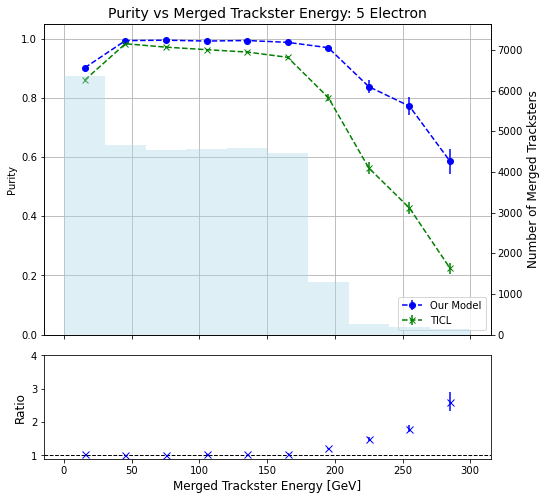

In [38]:

# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for Purity
# -----------------------------
def prepare_trackster_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first trackster_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',       # Use the first trackster_energy value.
        'reco_to_sim_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_ts = prepare_trackster_data(df_CL)
df_TICL_ts   = prepare_trackster_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of trackster_energy from df_CL.
min_energy_ts = df_CL_ts['trackster_energy'].min()
max_energy_ts = 300
n_bins_ts = 10  # Adjust the number of bins if desired.
energy_bins_ts = np.linspace(min_energy_ts, max_energy_ts, n_bins_ts + 1)

# Assign each trackster to an energy bin.
df_CL_ts['energy_bin'] = pd.cut(df_CL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)
df_TICL_ts['energy_bin']   = pd.cut(df_TICL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)

# -----------------------------
# Calculate Purity per Energy Bin
# -----------------------------
def aggregate_purity(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - Purity = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_ts = ('trackster_energy', 'count'),
        assoc_ts = ('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

agg_CL_ts = aggregate_purity(df_CL_ts)
agg_TICL_ts   = aggregate_purity(df_TICL_ts)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_ts-1)
agg_CL_ts = agg_CL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()
agg_TICL_ts   = agg_TICL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()

# -----------------------------
# Plot Purity vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_ts = (energy_bins_ts[:-1] + energy_bins_ts[1:]) / 2
bar_width_ts = energy_bins_ts[1] - energy_bins_ts[0]

purity_ratio = agg_CL_ts['purity'] / agg_TICL_ts['purity']
purity_ratio_error = purity_ratio * np.sqrt(
    (agg_CL_ts['purity_error'] / agg_CL_ts['purity'])**2 +
    (agg_TICL_ts['purity_error'] / agg_TICL_ts['purity'])**2
)

# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.1)  # Set spacing to zero

# Plot purity curves on the primary y-axis.
ax1.errorbar(bin_centers_ts, agg_CL_ts['purity'], yerr = agg_CL_ts['purity_error'],marker='o', linestyle='--', color = 'blue', label='Our Model')
ax1.errorbar(bin_centers_ts, agg_TICL_ts['purity'], yerr = agg_TICL_ts['purity_error'], marker='x', linestyle='--', color = 'green', label='TICL')
ax1.set_ylabel('Purity')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers_ts, agg_CL_ts['total_ts'], width=bar_width_ts, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_CL_ts['total_ts'].max() * 1.2)

ax2.errorbar(bin_centers_ts, purity_ratio, yerr=purity_ratio_error, fmt='x', color='blue', markersize=7)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Merged Trackster Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.9, 4)

plt.title(r'Purity vs Merged Trackster Energy: 5 Electron', fontsize=14)
plt.savefig("plots/Purity.png")

plt.show()


In [17]:
df_CL

event_index  cp_id  trackster_id  sim_to_reco_score  \
0                 0      0             0           1.000000   
1                 0      0             1           0.000612   
2                 0      0             2           0.999999   
3                 0      1             0           0.012499   
4                 0      1             1           1.000000   
...             ...    ...           ...                ...   
112315         9999      1             3           1.000000   
112316         9999      2             0           0.996653   
112317         9999      2             1           0.004227   
112318         9999      2             2           1.000000   
112319         9999      2             3           1.000000   

        reco_to_sim_score   cp_energy  trackster_energy  cp_avg_eta  \
0                1.000000  188.308315          9.989915    1.840491   
1                0.000000  188.308315        175.858238    1.840491   
2                0.999965  188.308315         26.876899    1.840491   
3                0.347336    9.099265          9.989915    1.907243   
4                1.000000    9.099265        175.858238    1.907243   
...                   ...         ...               ...         ...   
112315           1.000000   99.522923        104.605436    1.805638   
112316           0.000000  177.272805          2.578125    1.713318   
112317           0.000000  177.272805        161.909890    1.713318   
112318           1.000000  177.272805         93.743977    1.713318   
112319           1.000000  177.272805        104.605436    1.713318   

        cp_separation  energy_ratio  shared_energy  
0           15.686263      0.053051       0.000000  
1           15.686263      0.933885     175.858246  
2           15.686263      0.142728       0.048682  
3           15.686263      1.097882       7.780162  
4           15.686263     19.326643       0.000000  
...               ...           ...            ...  
112315       7.544651      1.051069       0.000000  
112316       7.544651      0.014543       2.578125  
112317       7.544651      0.913337     161.909897  
112318       7.544651      0.528812       0.000000  
112319       7.544651      0.590082       0.000000  

[112320 rows x 11 columns]

In [48]:
df_CL_best[df_CL_best['energy_bin']==0].head(30)

event_index  cp_id  trackster_id  sim_to_reco_score  reco_to_sim_score  \
1            0.0    1.0           0.0           0.012499           0.347336   
16           5.0    2.0           3.0           0.009990           0.000506   
32          12.0    1.0           0.0           0.008420           0.000000   
38          15.0    1.0           1.0           0.064914           0.000717   
45          17.0    1.0           3.0           0.006076           0.000943   
52          20.0    0.0           1.0           0.010263           0.000304   
69          27.0    0.0           4.0           0.016239           0.000000   
82          31.0    3.0           0.0           0.004054           0.993035   
151         53.0    1.0           3.0           0.015612           0.017553   
158         55.0    2.0           2.0           0.025984           0.000000   
162         57.0    0.0           1.0           0.022217           0.009768   
242         83.0    3.0           3.0           0.029387           0.996097   
247         84.0    3.0           3.0           0.005749           0.000202   
262         90.0    0.0           2.0           0.027358           0.000000   
295        103.0    1.0           2.0           0.007292           0.001330   
322        113.0    0.0           2.0           0.007222           0.002783   
331        115.0    2.0           3.0           0.008204           0.929196   
332        115.0    3.0           0.0           0.415803           0.999645   
387        132.0    3.0           3.0           0.034135           0.994571   
433        150.0    2.0           2.0           0.077696           0.983274   
485        174.0    2.0           2.0           0.983235           0.339059   
515        187.0    0.0           1.0           0.003854           0.898049   
525        189.0    1.0           3.0           0.027274           0.000000   
543        194.0    2.0           5.0           0.016624           0.221554   
553        198.0    1.0           4.0           0.022165           0.000000   
562        200.0    0.0           0.0           0.003960           0.000000   
633        221.0    2.0           3.0           0.008729           0.014896   
635        221.0    4.0           4.0           0.013347           0.001937   
638        222.0    2.0           3.0           0.571188           0.000000   
646        225.0    2.0           2.0           0.011906           0.020306   

     cp_energy  trackster_energy  cp_avg_eta  cp_separation  energy_ratio  \
1     9.099265          9.989915    1.907243      15.686263      1.097882   
16   11.686752         10.277142    2.403381       0.502442      0.879384   
32   14.012591         12.504085    2.247084      16.714241      0.892346   
38   11.809575          9.993752    1.943904      19.366934      0.846241   
45    9.895203          9.266910    2.554589      18.156643      0.936505   
52   13.305214         11.947965    2.484718      11.750250      0.897991   
69    8.893972          7.505948    2.302306      18.940706      0.843937   
82    5.794643        166.257767    2.009197       8.281199     28.691631   
151  14.109016         14.075037    1.736442      18.562239      0.997592   
158  11.700274          7.323340    1.911258      16.231575      0.625912   
162   9.797369          9.457780    2.243729      10.207309      0.965339   
242   5.196278        154.132789    2.065536       9.251271     29.662154   
247  13.319265         12.131087    1.871454      10.481378      0.910793   
262   9.939250          8.318207    2.000861      10.085140      0.836905   
295  14.751345         13.246514    1.716767       8.255926      0.897987   
322  14.602993         13.689352    2.504535      10.267385      0.937435   
331  14.458534         71.338293    2.117450      16.414644      4.933992   
332   6.532901        221.933974    2.008383      16.414644     33.971734   
387  10.518205        196.381384    1.838703      10.338438     18.670618   
433  12.633560 

# Response and Resolution

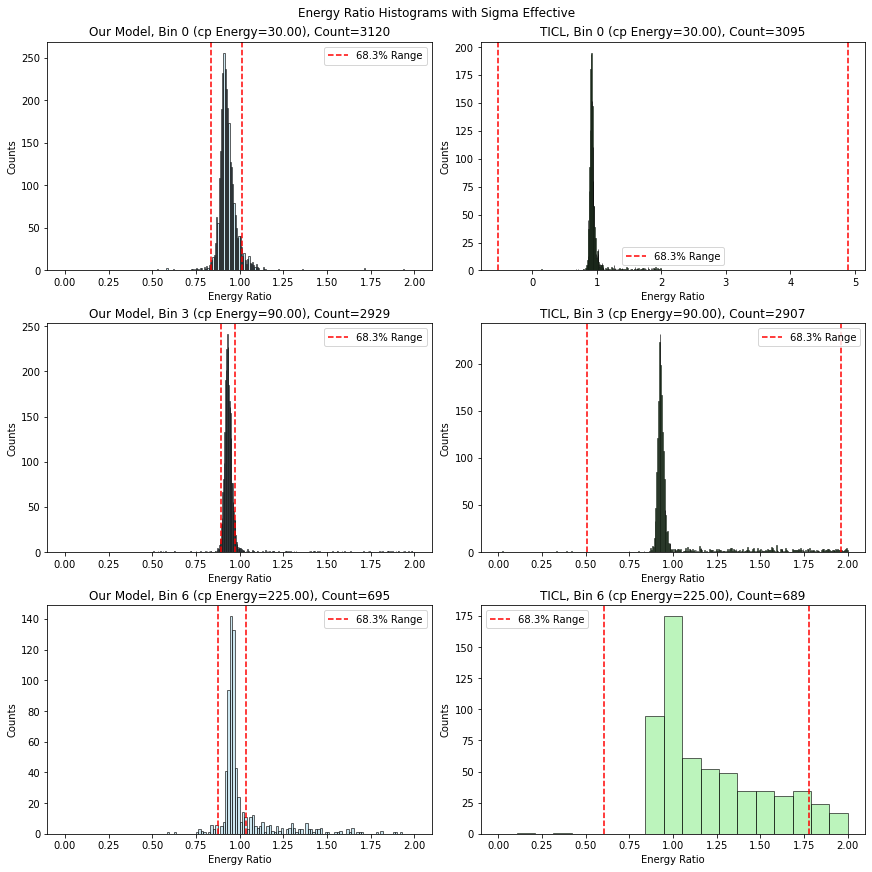

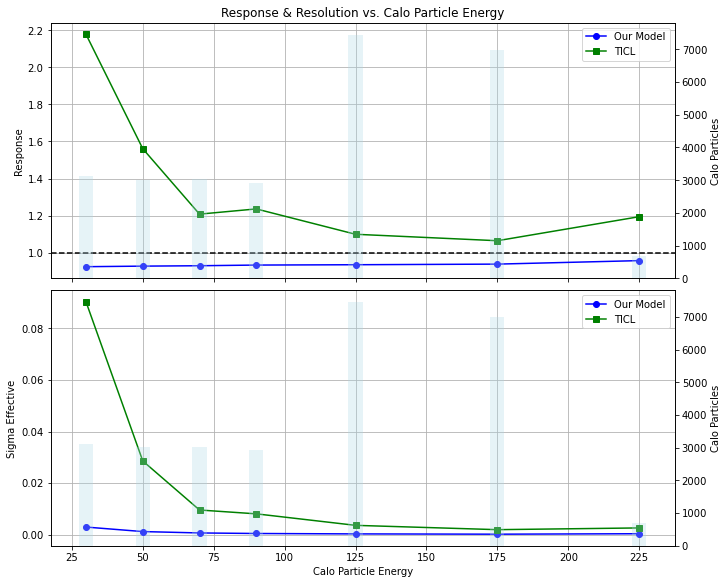

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# 1. Preprocessing and Association Selection for Calo Particles
# ====================================================
def process_cp_dataframe(df):
    df = df.copy()
    for col in ['cp_id', 'sim_to_reco_score', 'reco_to_sim_score', 'cp_energy', 'energy_ratio']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df_cp = df[df['sim_to_reco_score'] < 1]
    df_cp = df_cp.loc[df_cp.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    return df_cp

df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# ====================================================
# 2. Binning by Calo Particle Energy (cp_energy)
# ====================================================
energy_bins = np.array([20, 40, 60, 80, 100, 150, 200, 250])  # Manually defined bins
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2  # Compute bin centers

df_CL_cp['energy_bin'] = np.digitize(df_CL_cp['cp_energy'], bins=energy_bins, right=True) - 1
df_TICL_cp['energy_bin'] = np.digitize(df_TICL_cp['cp_energy'], bins=energy_bins, right=True) - 1

# ====================================================
# 3. Compute Sigma Effective in Each Energy Bin
# ====================================================
def compute_sigma_effective(df, num_bins):
    fitted_mean, sigma_eff, counts = [], [], []
    
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        
        sorted_data = np.sort(bin_data)
        n_points = len(sorted_data)
        
        if n_points > 0:
            window_size = int(0.683 * n_points)
            min_width = np.inf
            best_range = (None, None)
            
            for i in range(n_points - window_size):
                width = sorted_data[i + window_size] - sorted_data[i]
                if width < min_width:
                    min_width = width
                    best_range = (sorted_data[i], sorted_data[i + window_size])
                    
            mu_eff = (best_range[0] + best_range[1]) / 2
            sigma_eff_val = (best_range[1] - best_range[0])
        else:
            mu_eff, sigma_eff_val = np.nan, np.nan
        
        fitted_mean.append(mu_eff)
        sigma_eff.append(sigma_eff_val)
    
    return np.array(fitted_mean), np.array(sigma_eff), np.array(counts)

n_bins = len(energy_bins) - 1  # Update number of bins
fitted_mean_CL, sigma_eff_CL, counts_CL = compute_sigma_effective(df_CL_cp, n_bins)
fitted_mean_TICL, sigma_eff_TICL, counts_TICL = compute_sigma_effective(df_TICL_cp, n_bins)

# ====================================================
# 4. Plot Histograms with Sigma Effective
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
fig_hist, axs = plt.subplots(len(selected_bins), 2, figsize=(12, 4 * len(selected_bins)), constrained_layout=True)

for i, b in enumerate(selected_bins):
    for j, (df, mean, sigma, label, color, ax) in enumerate(zip(
            [df_CL_cp, df_TICL_cp],
            [fitted_mean_CL, fitted_mean_TICL],
            [sigma_eff_CL, sigma_eff_TICL],
            ['Our Model', 'TICL'],
            ['lightblue', 'lightgreen'],
            axs[i] if len(selected_bins) > 1 else [axs])):
        
        data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        n, bins, _ = ax.hist(data, bins='auto', range=(0, 2), color=color, alpha=0.6, edgecolor='k')
        
        ax.axvline(mean[b] - sigma[b], color='r', linestyle='--', label=f'68.3% Range')
        ax.axvline(mean[b] + sigma[b], color='r', linestyle='--')
        
        ax.set_title(f'{label}, Bin {b} (cp Energy={bin_centers[b]:.2f}), Count={len(data)}')
        ax.set_xlabel('Energy Ratio')
        ax.set_ylabel('Counts')
        ax.legend()

plt.suptitle('Energy Ratio Histograms with Sigma Effective')
plt.show()

# ====================================================
# 5. Plot Response and Resolution vs. cp Energy Bin Centers
# ====================================================
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

ax_resp.plot(bin_centers, fitted_mean_CL, 'bo-', label='Our Model')
ax_resp.plot(bin_centers, fitted_mean_TICL, 'gs-', label='TICL')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response')
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy')
ax_resp.legend()
ax_resp.grid()

ax_resp2 = ax_resp.twinx()
ax_resp2.bar(bin_centers, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_resp2.set_ylabel('Calo Particles')

ax_res.plot(bin_centers, sigma_eff_CL / bin_centers, 'bo-', label='Our Model')
ax_res.plot(bin_centers, sigma_eff_TICL / bin_centers, 'gs-', label='TICL')
ax_res.set_xlabel('Calo Particle Energy')
ax_res.set_ylabel('Sigma Effective')
ax_res.legend()
ax_res.grid()

ax_res2 = ax_res.twinx()
ax_res2.bar(bin_centers, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles')

plt.show()


In [42]:
df_CL_best

event_index  cp_id  trackster_id  sim_to_reco_score  reco_to_sim_score  \
3              1.0    0.0           0.0           0.002063                0.0   
13             4.0    0.0           1.0           0.002249                0.0   
28            10.0    0.0           1.0           0.001811                0.0   
34            13.0    0.0           0.0           0.005799                0.0   
66            25.0    0.0           0.0           0.003063                0.0   
...            ...    ...           ...                ...                ...   
29831       9967.0    0.0           0.0           0.000958                0.0   
29856       9975.0    0.0           0.0           0.001471                0.0   
29878       9982.0    0.0           0.0           0.000752                0.0   
29879       9983.0    0.0           0.0           0.000981                0.0   
29930       9998.0    0.0           0.0           0.001866                0.0   

        cp_energy  trackster_energy  cp_avg_eta  cp_separation  energy_ratio  \
3       68.400436         62.828481    2.708550            0.0      0.918539   
13     183.513630        165.294722    2.647908            0.0      0.900722   
28     132.009307        121.640132    1.953221            0.0      0.921451   
34      24.704719         22.125333    2.280467            0.0      0.895591   
66      40.700294         36.798931    2.537960            0.0      0.904144   
...           ...               ...         ...            ...           ...   
29831  107.562881         99.452581    2.359559            0.0      0.924599   
29856   85.695254         79.263152    2.165170            0.0      0.924942   
29878  164.449084        152.316652    1.862390            0.0      0.926224   
29879   93.825359         87.439190    2.009622            0.0      0.931936   
29930   91.635889         83.185328    2.430932            0.0      0.907781   

       shared_energy  single_energy     ratio  energy_bin  
3          62.828484      69.588043  0.902863         4.0  
13        165.294708     194.395737  0.850300         8.0  
28        121.640137     136.673721  0.890004         7.0  
34         22.125334      24.822613  0.891338         1.0  
66         36.798931      43.453068  0.846866         3.0  
...              ...            ...       ...         ...  
29831      99.452583     108.166328  0.919441         6.0  
29856      79.263153      86.959053  0.911500         5.0  
29878     152.316650     163.504257  0.931576         7.0  
29879      87.439186      93.433441  0.935845         6.0  
29930      83.185326      91.460991  0.909517         6.0  

[2068 rows x 14 columns]

In [36]:
print(len(df_CL_best))

2068


In [29]:
df_CL[df_CL['event_index'] == 1.0]

event_index  cp_id  trackster_id  sim_to_reco_score  reco_to_sim_score  \
9            1      0             0           0.002063                0.0   

   cp_energy  trackster_energy  cp_avg_eta  cp_separation  energy_ratio  \
9  68.400436         62.828481     2.70855            0.0      0.918539   

   shared_energy  
9      62.828484

In [39]:
single_energy = data_file['simtrackstersCP;3']['regressed_energy'].array()
skim_mask = []
for e in single_energy:
    if 1 == len(e) :
        skim_mask.append(True)
    else:
        skim_mask.append(False)
single_energy = single_energy[skim_mask]

In [40]:
print(len(single_energy))

2068


In [35]:
print(single_energy[1])

[69.6]


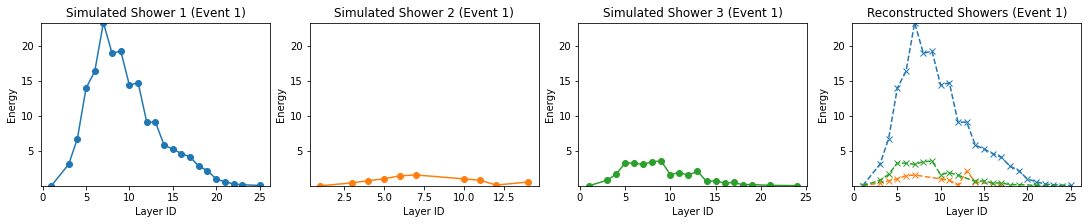

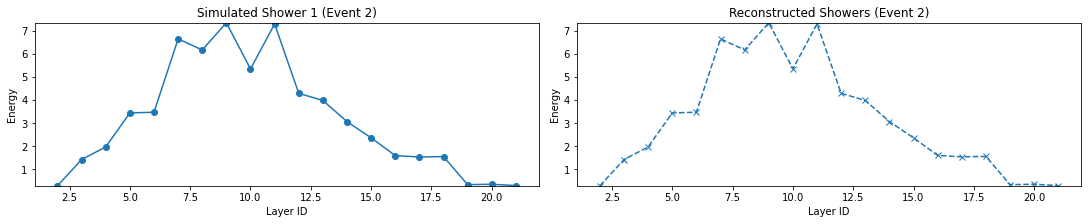

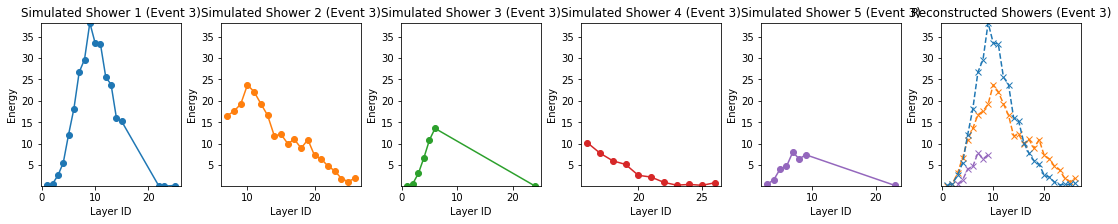

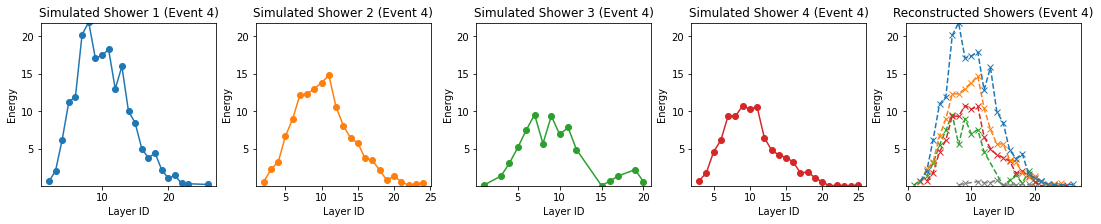

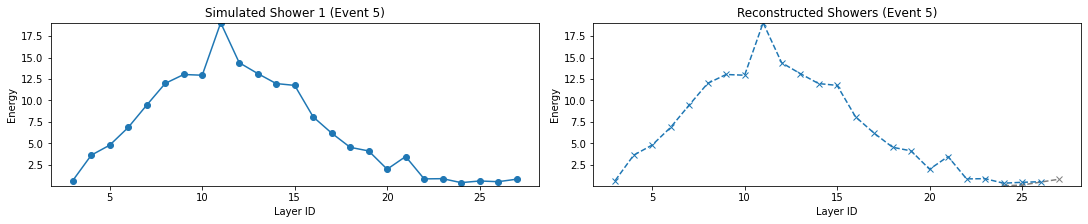

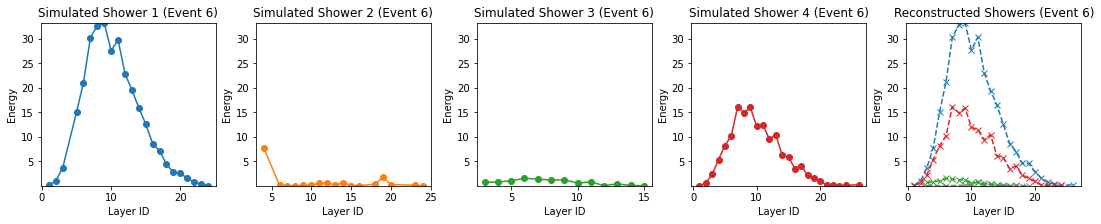

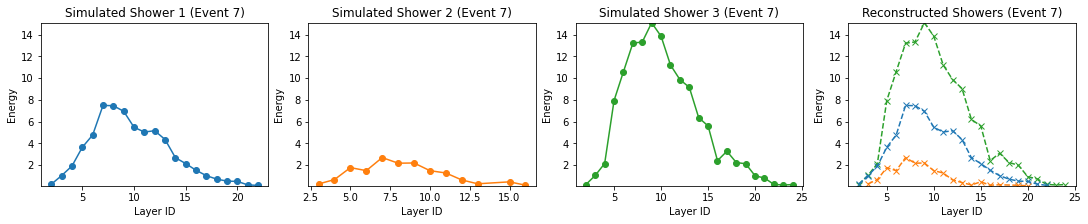

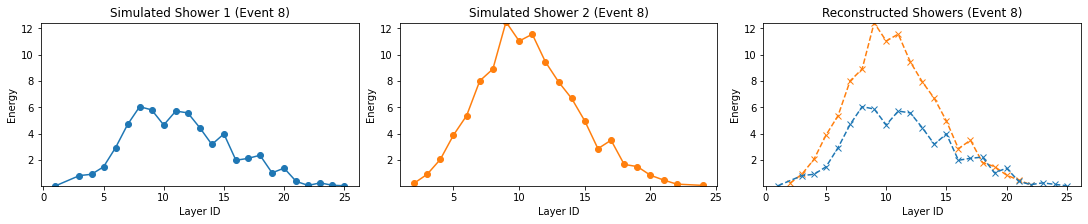

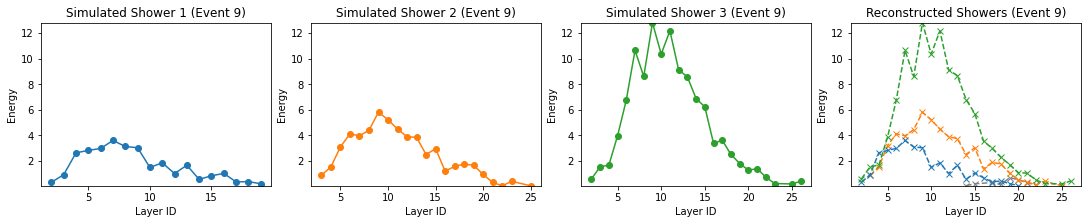

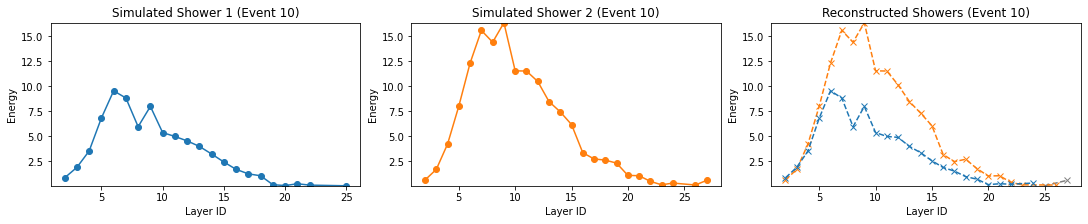

In [28]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters;3']['cluster_layer_id'].array()

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=10):
    # Define unique colors for caloparticles
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations

        # Simulated particle shower
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)

        # Reconstructed particle shower
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)

        # Calculate sim_to_reco score and determine associations


        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            cp_energy = np.sum(event_energies[caloparticle] / Calo_multi)
            
            # Loop over all Tracksters
            max_shared_energy = 0.0
            best_tst_idx = None
            
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                
                
                shared_det_ids = set(calo_det_id for calo_det_id in caloparticle).intersection(set(trackster))
                if not shared_det_ids:
                    continue  # No shared det_ids

                # Calculate shared_energy
                shared_energy = np.sum(event_energies[list(shared_det_ids)])

                # Check if shared_energy meets the threshold
                if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                    max_shared_energy = shared_energy
                    best_tst_idx = trackster_idx

            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx
                    
        
        
        # Determine energy range from reconstructed showers for consistent y-axis
        min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
        max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
    
    
        # Plot simulated profiles
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'], marker='o', linestyle='-', color=colors[idx % len(colors)])
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1} (Event {event_index + 1})')
            ax.set_xlabel('Layer ID')
            ax.set_ylabel('Energy')

        # Plot all reconstructed profiles in a single plot
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Determine color based on association
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = colors[associated_cp[0] % len(colors)] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'], marker='x', linestyle='--', color=color)
        ax.set_ylim(min_energy, max_energy)
        ax.set_title(f'Reconstructed Showers (Event {event_index + 1})')
        ax.set_xlabel('Layer ID')
        ax.set_ylabel('Energy')

        # Show the plots
        plt.show()

events_ours = calculate_all_event_profile_data(GT_ind_filt, energies, recon_ind, layer, GT_mult_filt)


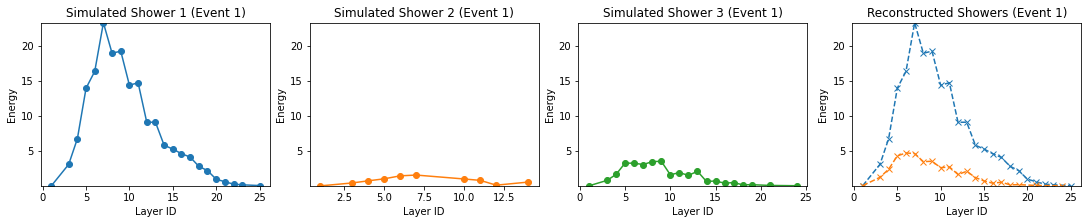

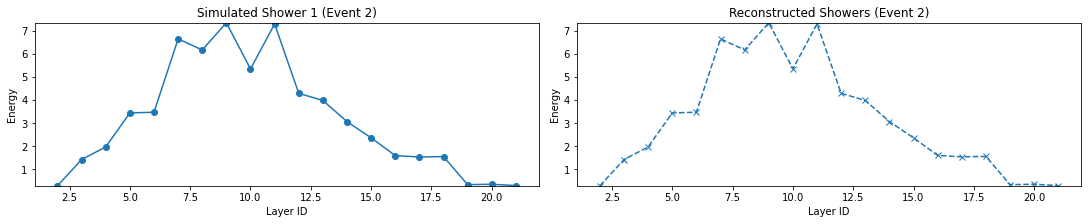

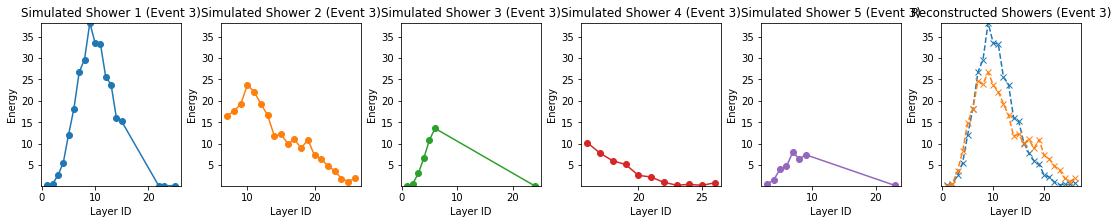

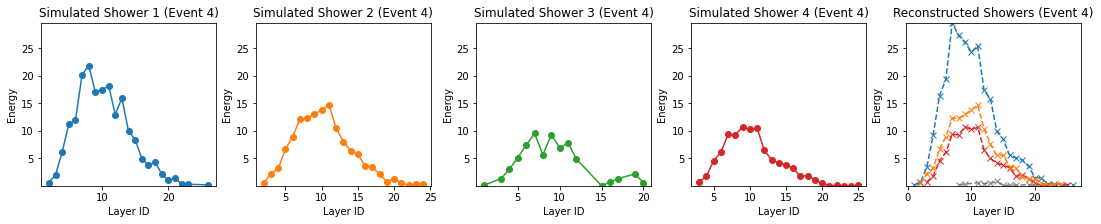

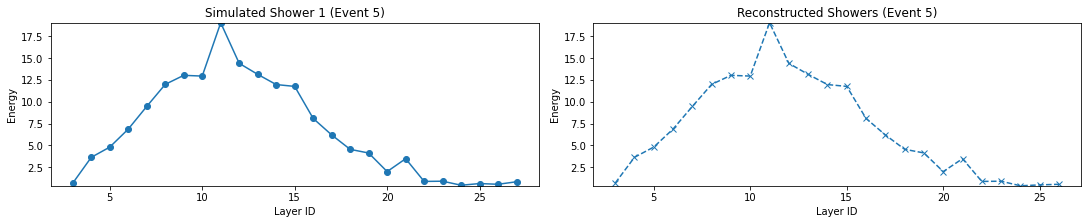

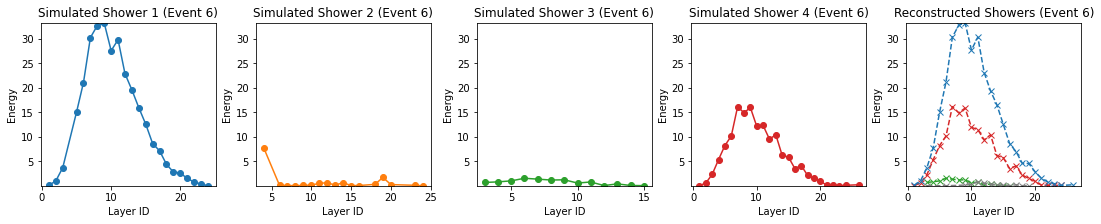

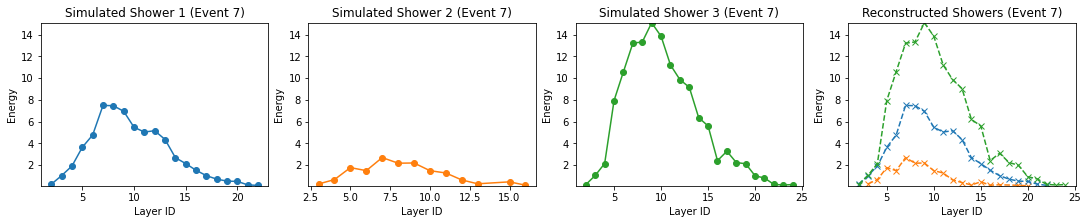

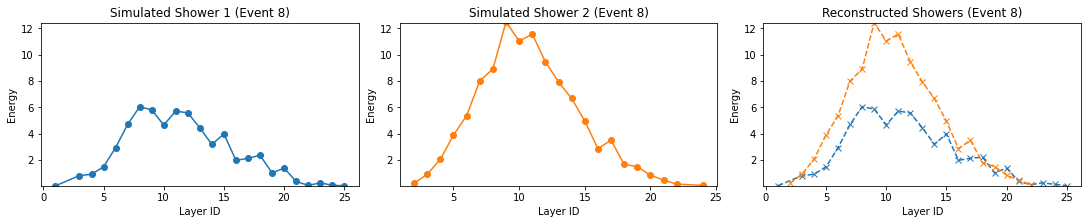

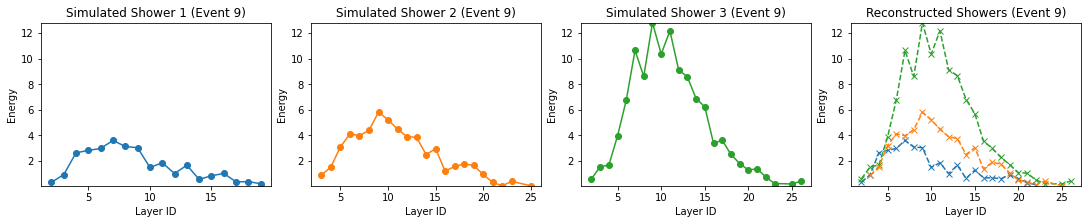

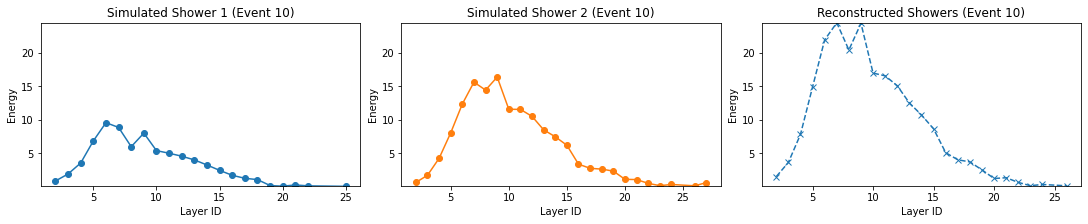

In [29]:
events_TICL = calculate_all_event_profile_data(GT_ind_filt, energies, MT_ind_filt, layer, GT_mult_filt)

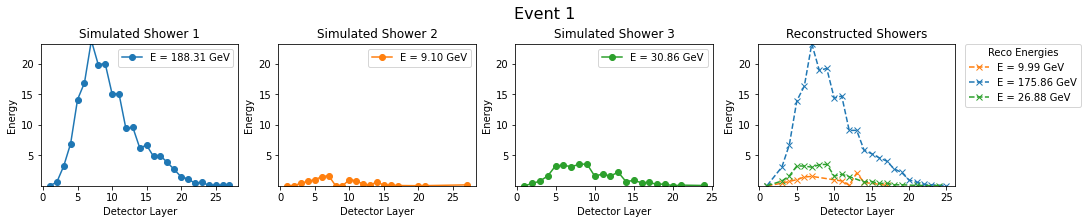

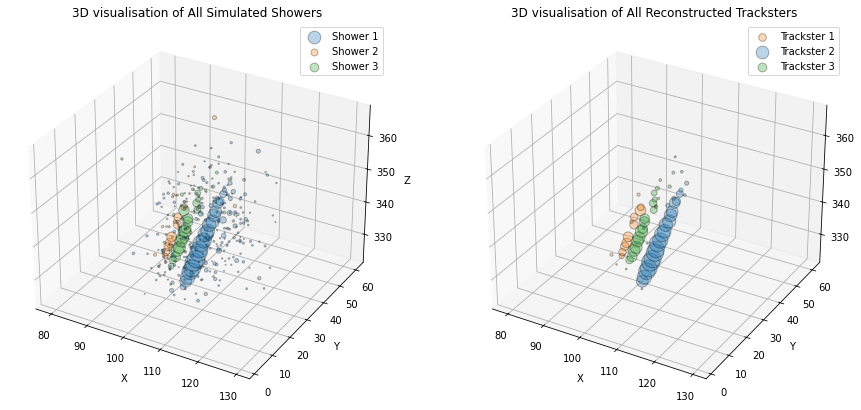

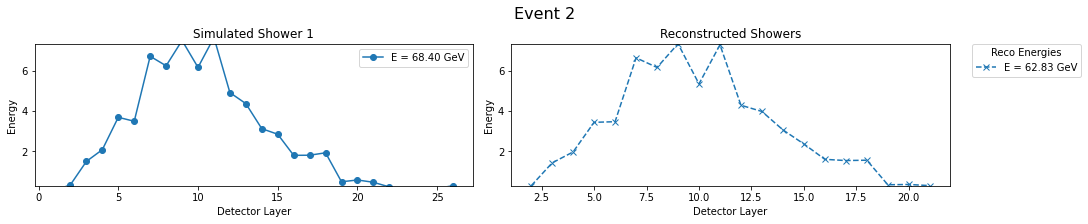

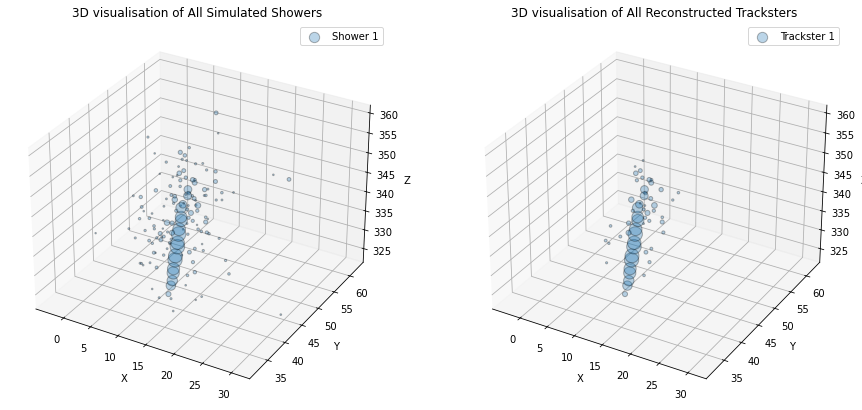

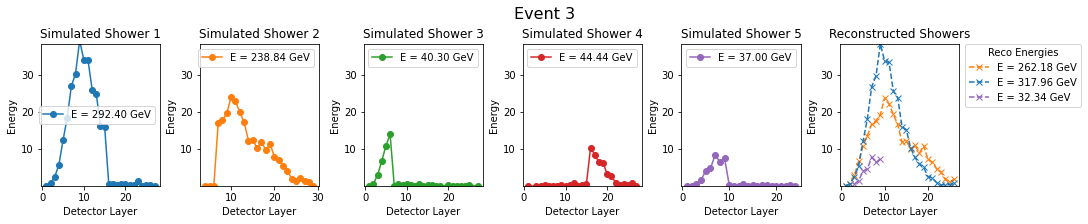

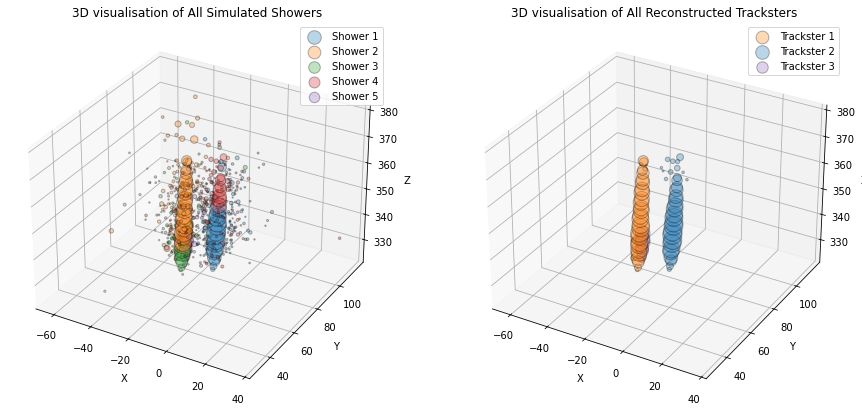

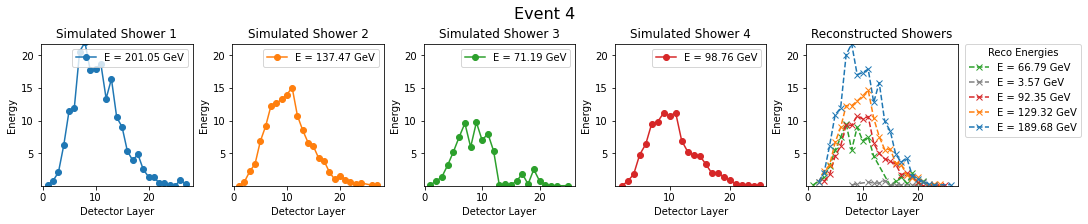

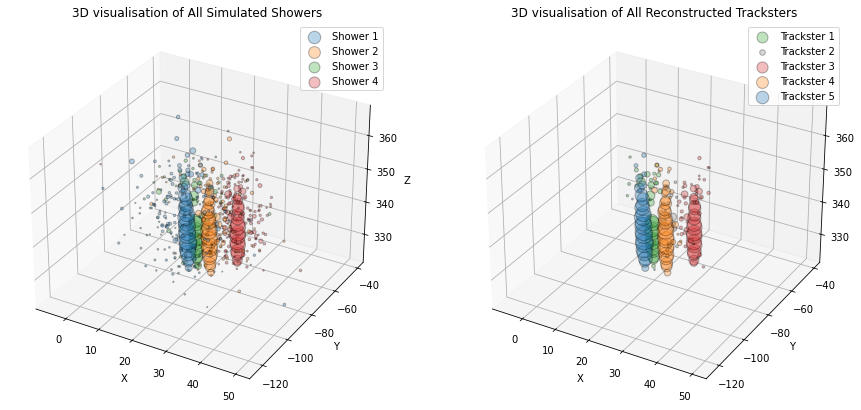

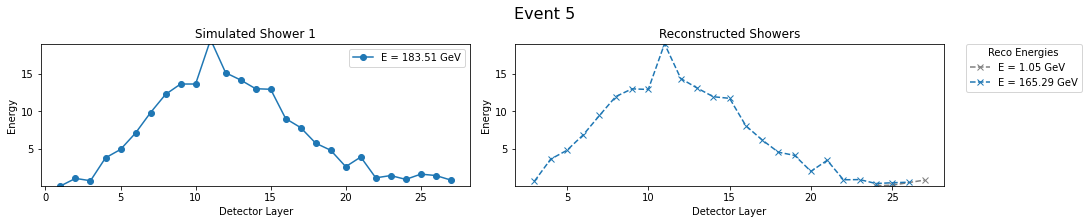

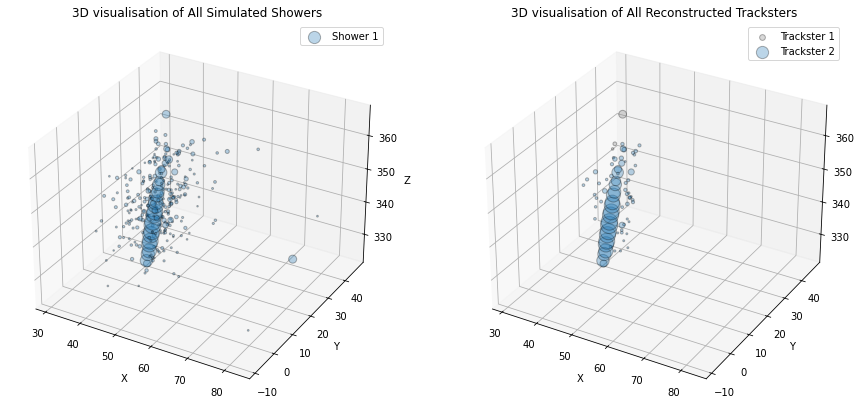

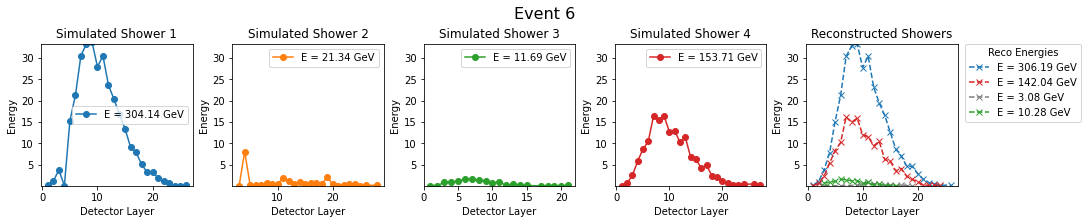

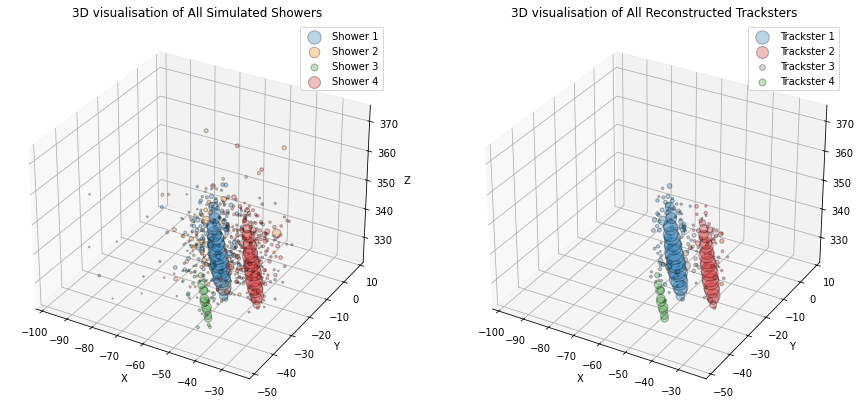

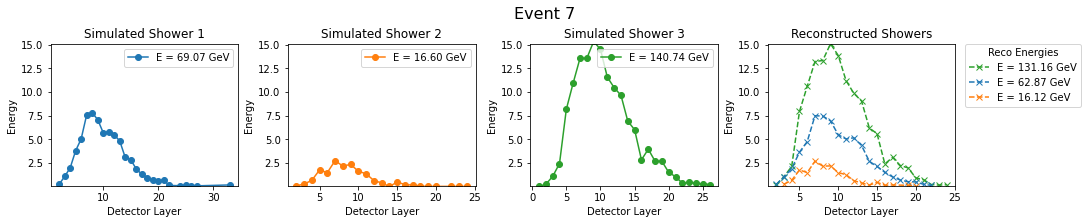

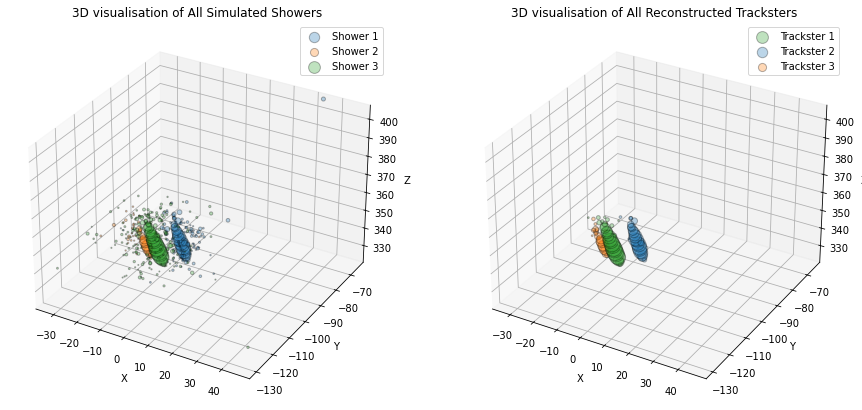

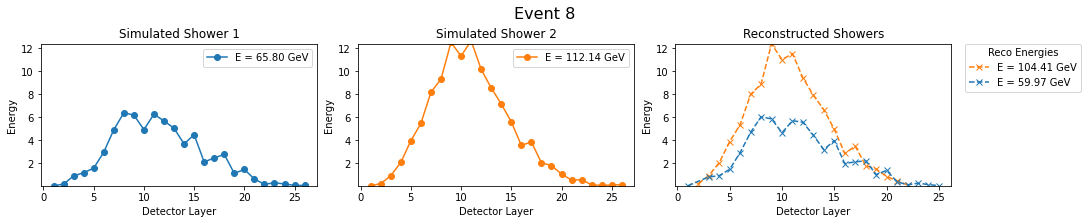

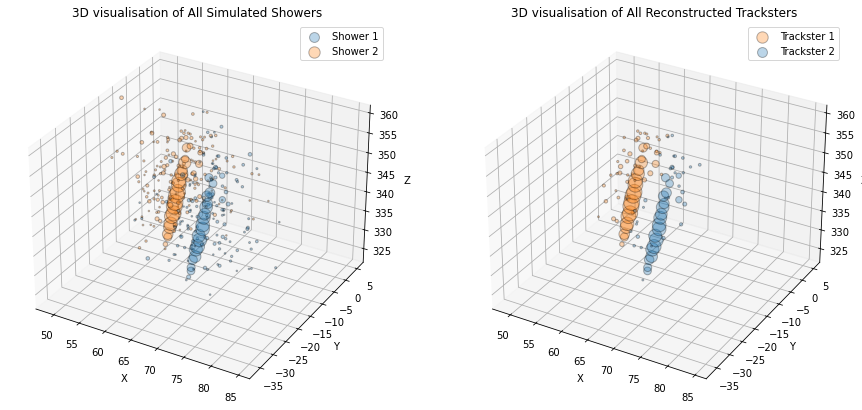

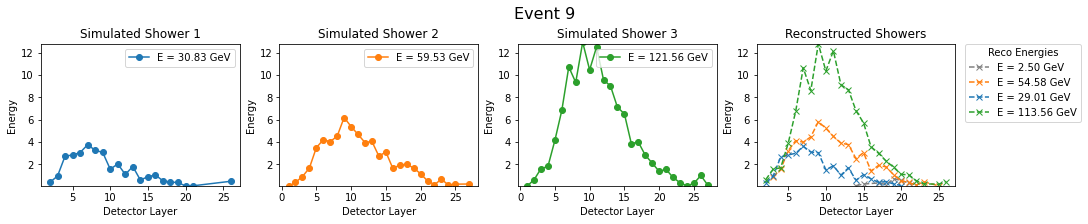

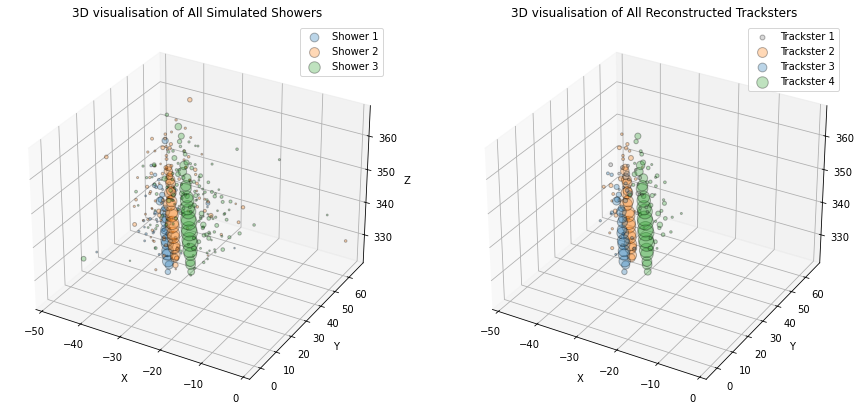

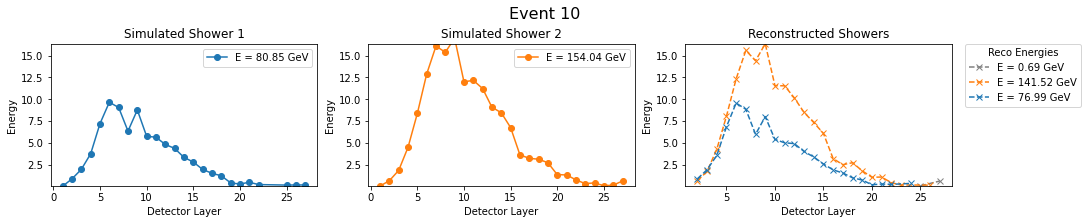

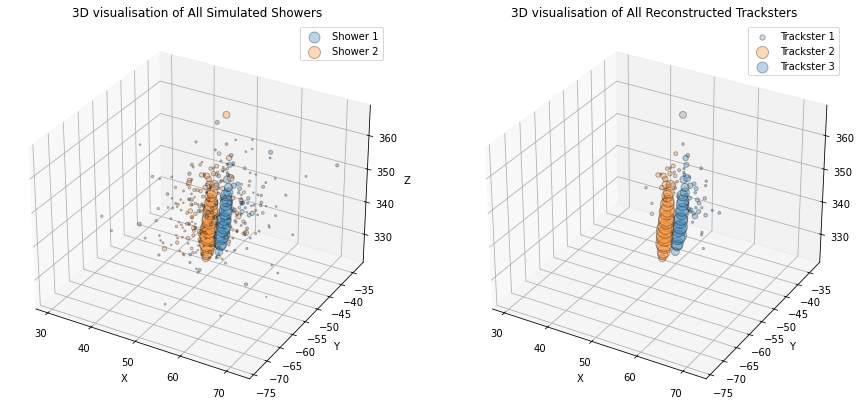

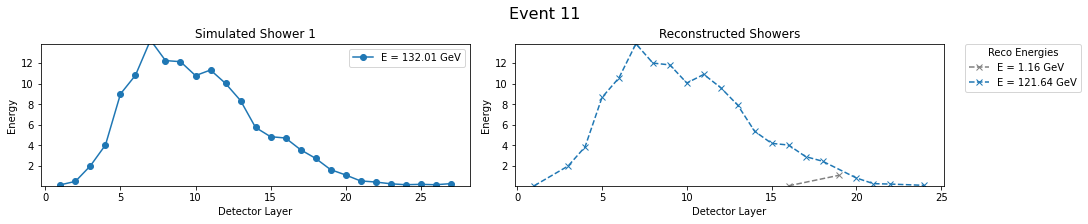

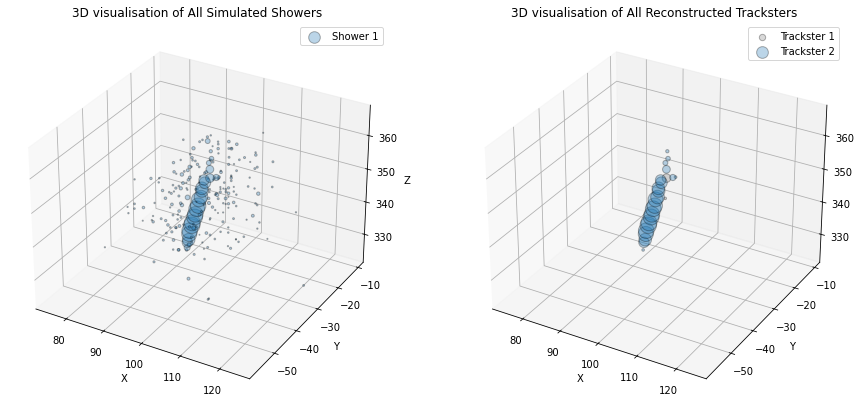

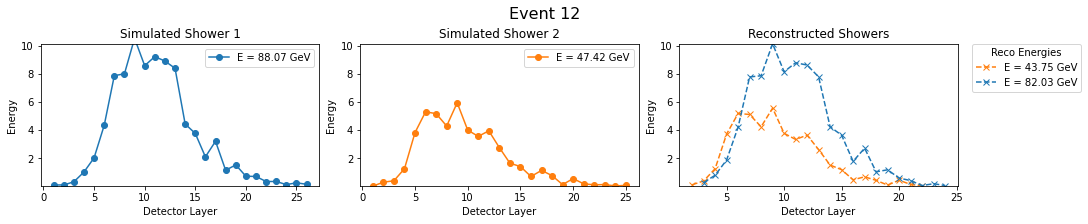

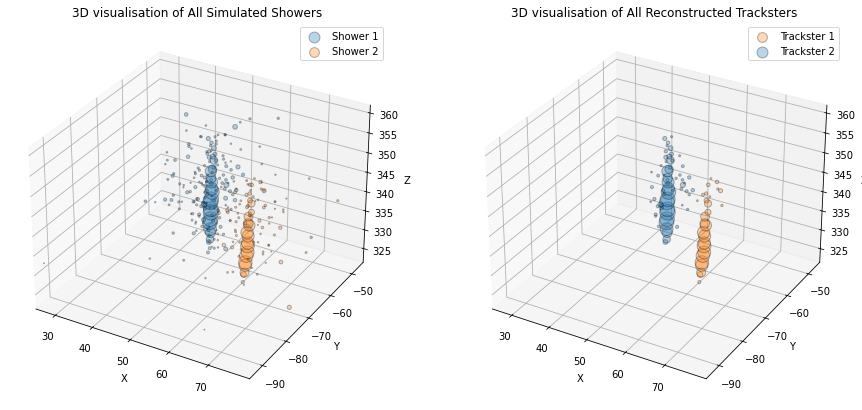

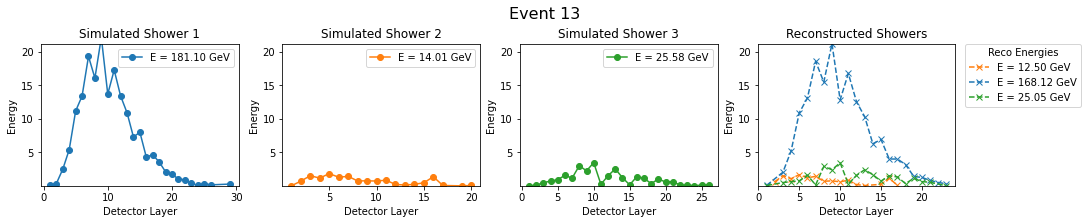

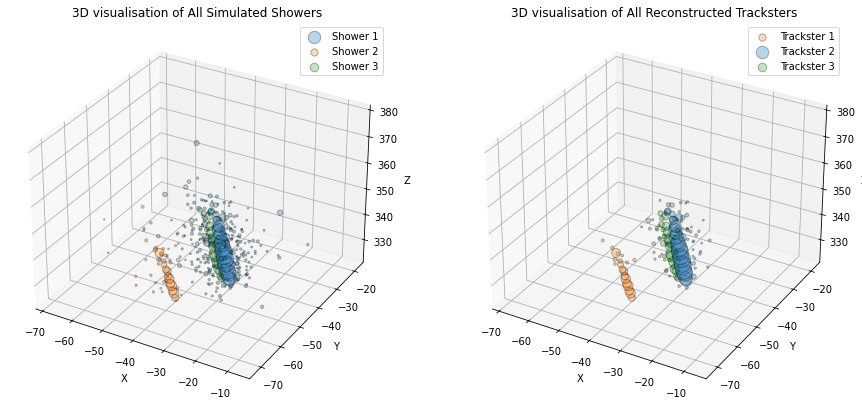

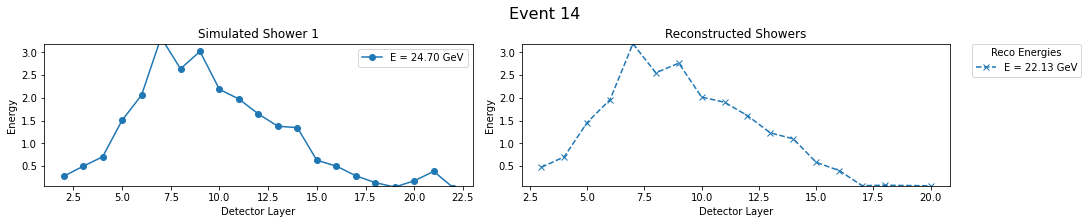

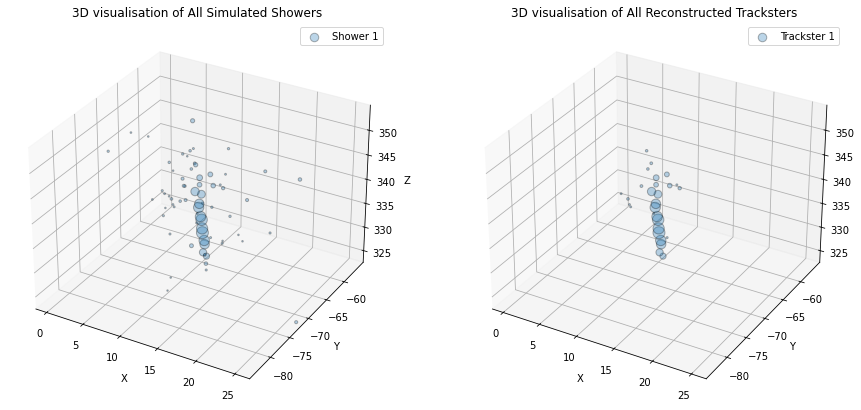

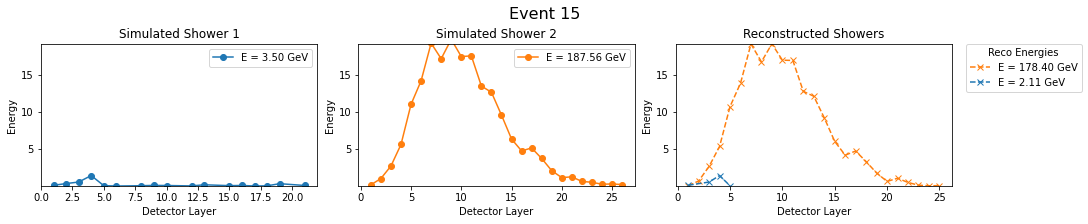

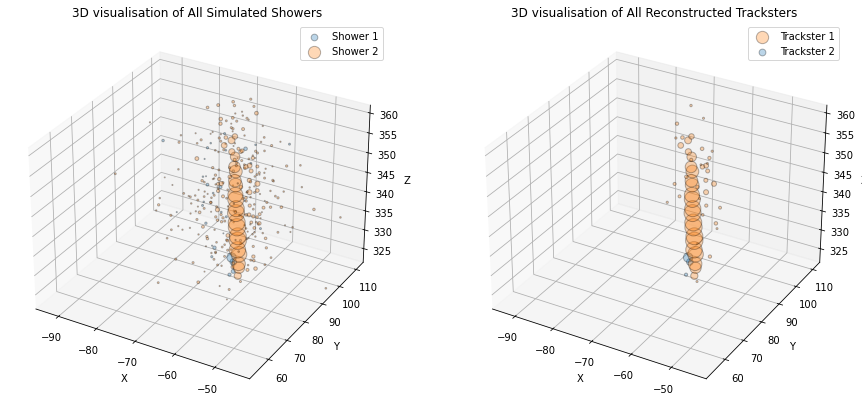

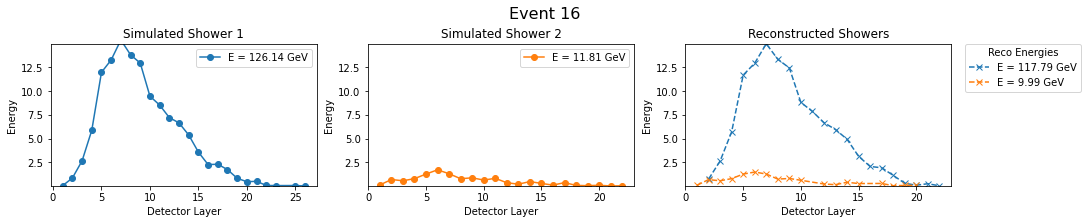

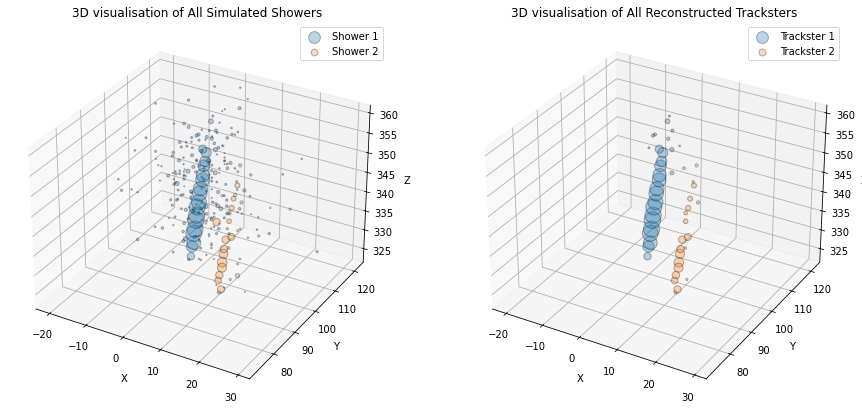

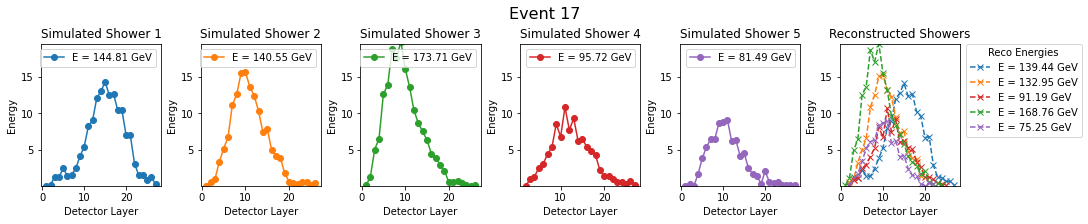

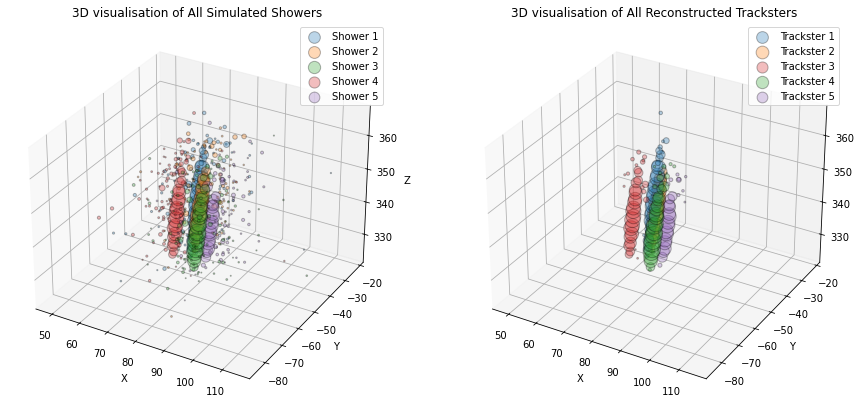

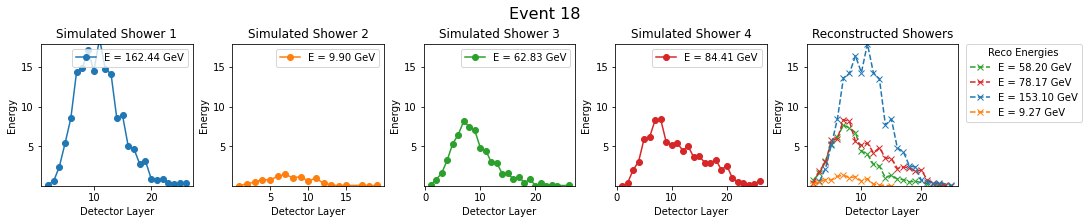

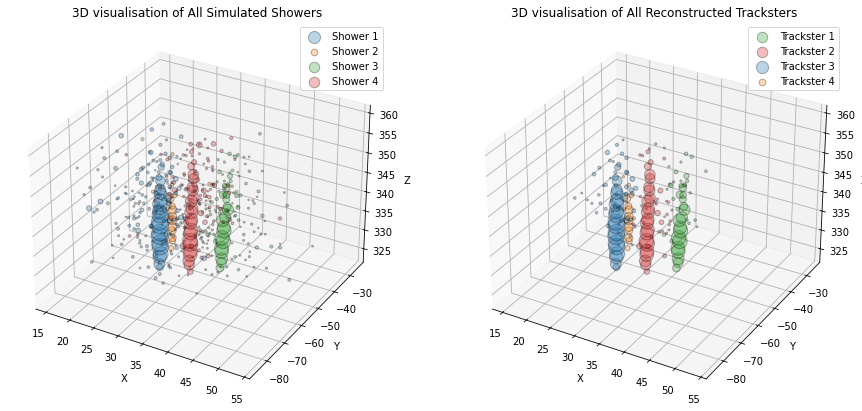

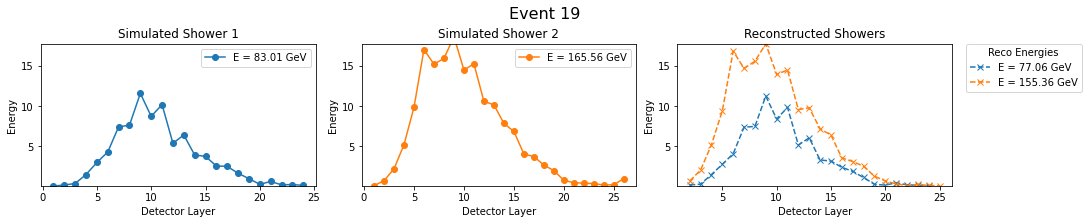

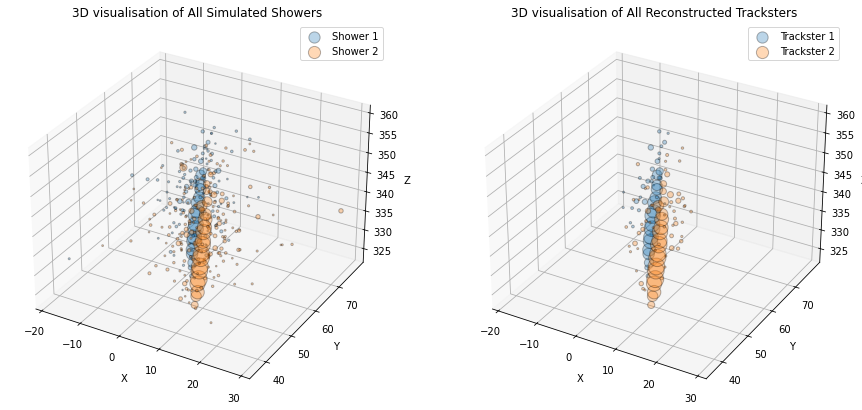

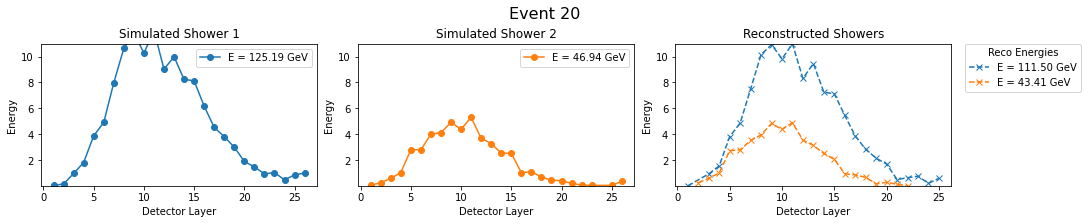

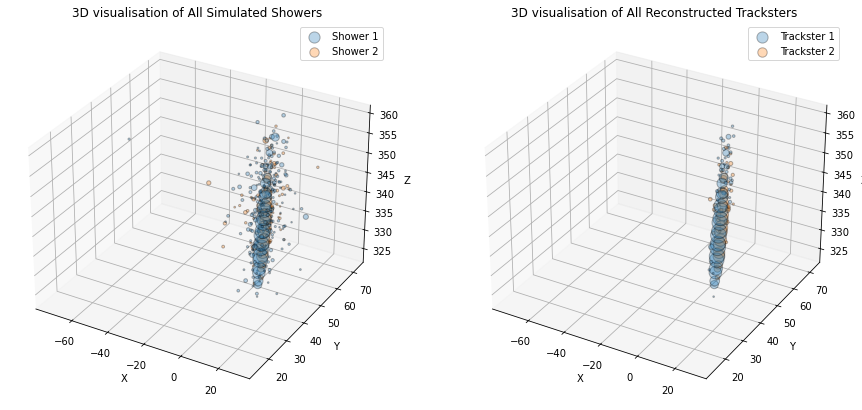

In [32]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Define LC_x, LC_y, LC_z somewhere or import if needed.
# For example purposes, assume they are defined globally.

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=20):
    # Define unique colors (using Tableau colors)
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]
        event_LC_x = LC_x[event_index]
        event_LC_y = LC_y[event_index]
        event_LC_z = LC_z[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations
        cp_lc_pos_all = []
        cp_lc_energies_all = []
        tst_lc_pos_all = []
        tst_lc_energies_all = []
        total_cp_energies = []
        total_tst_energies = []

        # --- Simulated particle shower ---
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            # Divide energy by multi (assume event_multi[cp_idx] corresponds to this caloparticle)
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)
            
            cp_lc_pos_all.append([event_LC_x[caloparticle], event_LC_y[caloparticle], event_LC_z[caloparticle]])
            cp_lc_energies_all.append(cp_lc_energies)
            total_cp_energies.append(layer_energy_cp['energy'].sum())

        # Build a dedicated color map for simulated showers
        cp_color_map = {cp_idx: colors[cp_idx % len(colors)] for cp_idx in range(len(simulated_profiles))}

        # --- Reconstructed particle shower ---
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)
            
            tst_lc_pos_all.append([event_LC_x[trackster], event_LC_y[trackster], event_LC_z[trackster]])
            tst_lc_energies_all.append(tst_lc_energies)
            total_tst_energy = np.sum(tst_lc_energies)
            total_tst_energies.append(layer_energy_tst['energy'].sum())

        # --- Calculate sim_to_reco score and determine associations ---
        for calo_idx, caloparticle in enumerate(caloparticles):
            # Use corresponding multiplicity for this calo particle
            Calo_multi = event_multi[calo_idx]
            cp_energy = np.sum(event_energies[caloparticle] / Calo_multi)
            
            max_shared_energy = 0.0
            best_tst_idx = None
            
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate shared detector IDs (assuming caloparticle and trackster are lists/arrays of detector IDs)
                shared_det_ids = set(caloparticle).intersection(set(trackster))
                if not shared_det_ids:
                    continue  # No shared detector IDs

                # Calculate shared energy
                shared_energy = np.sum(event_energies[list(shared_det_ids)])

                # Check if shared_energy meets the threshold
                if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                    max_shared_energy = shared_energy
                    best_tst_idx = trackster_idx
                    
            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx

        # --- Determine energy range from reconstructed showers for consistent y-axis ---
        # (if there is at least one reconstructed profile)
        if reconstructed_profiles:
            min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
            max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
        else:
            min_energy, max_energy = 0, 1

        # --- Plot simulated profiles (2D) ---
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)
        fig.suptitle(f'Event {event_index + 1}', fontsize=16)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'],
                    marker='o', linestyle='-', color=cp_color_map[idx],
                    label=f"E = {total_cp_energies[idx]:.2f} GeV")
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1}')
            ax.set_xlabel('Detector Layer')
            ax.set_ylabel('Energy')
            ax.legend()

        # --- Plot all reconstructed profiles in a single 2D plot ---
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Look up the corresponding calo (if any) using associations
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            # Use the simulated shower color if there is an association; otherwise, default to gray
            color = cp_color_map[associated_cp[0]] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'],
                    marker='x', linestyle='--', color=color,
                    label=f"E = {total_tst_energies[idx]:.2f} GeV")
            
        ax.set_ylim(min_energy, max_energy)
        ax.set_title('Reconstructed Showers')
        ax.set_xlabel('Detector Layer')
        ax.set_ylabel('Energy')
        ax.legend(title='Reco Energies', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

        # --- Determine global energy scale and axis limits for 3D plots ---
        all_energies = np.concatenate(cp_lc_energies_all + tst_lc_energies_all)
        global_min_energy, global_max_energy = np.min(all_energies), np.max(all_energies)
        x_lim = [min(event_LC_x), max(event_LC_x)]
        y_lim = [min(event_LC_y), max(event_LC_y)]
        z_lim = [min(event_LC_z), max(event_LC_z)]

        # --- 3D Scatter Plot for All Simulated Layer Clusters ---
        fig3d = plt.figure(figsize=(15, 7))
        ax_3d = fig3d.add_subplot(1, 2, 1, projection='3d')
        for idx, (pos, energies_) in enumerate(zip(cp_lc_pos_all, cp_lc_energies_all)):
            x, y, z = pos
            sizes = np.log1p(np.array(energies_)) * 100  # Scale sizes for visibility
            ax_3d.scatter(x, y, z, c=cp_color_map[idx], alpha=0.3, s=sizes, edgecolors='k', label=f'Shower {idx+1}')
        
        ax_3d.set_xlim(x_lim)
        ax_3d.set_ylim(y_lim)
        ax_3d.set_zlim(z_lim)
        ax_3d.set_title('3D visualisation of All Simulated Showers')
        ax_3d.set_xlabel('X')
        ax_3d.set_ylabel('Y')
        ax_3d.set_zlabel('Z')
        ax_3d.legend()

        # --- 3D Scatter Plot for All Reconstructed Tracksters ---
        ax_3d_reco = fig3d.add_subplot(1, 2, 2, projection='3d')
        for idx, (pos, energies_) in enumerate(zip(tst_lc_pos_all, tst_lc_energies_all)):
            x, y, z = pos
            sizes = np.log1p(np.array(energies_)) * 100  # Scale sizes for visibility
            # Look up association for the trackster to decide its color
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = cp_color_map[associated_cp[0]] if associated_cp else 'gray'
            ax_3d_reco.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k', label=f'Trackster {idx+1}')
        
        ax_3d_reco.set_xlim(x_lim)
        ax_3d_reco.set_ylim(y_lim)
        ax_3d_reco.set_zlim(z_lim)
        ax_3d_reco.set_title('3D visualisation of All Reconstructed Tracksters')
        ax_3d_reco.set_xlabel('X')
        ax_3d_reco.set_ylabel('Y')
        ax_3d_reco.set_zlabel('Z')
        ax_3d_reco.legend()

        plt.show()

        

events = calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, GT_mult)

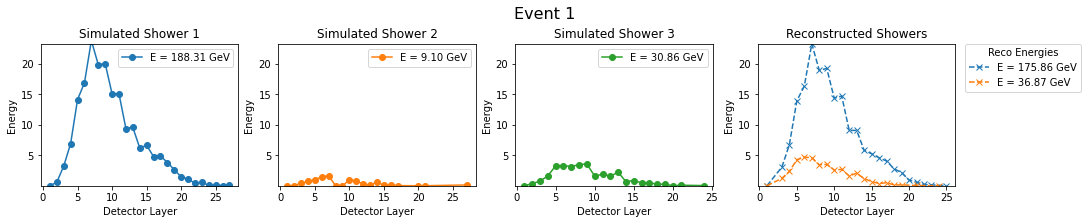

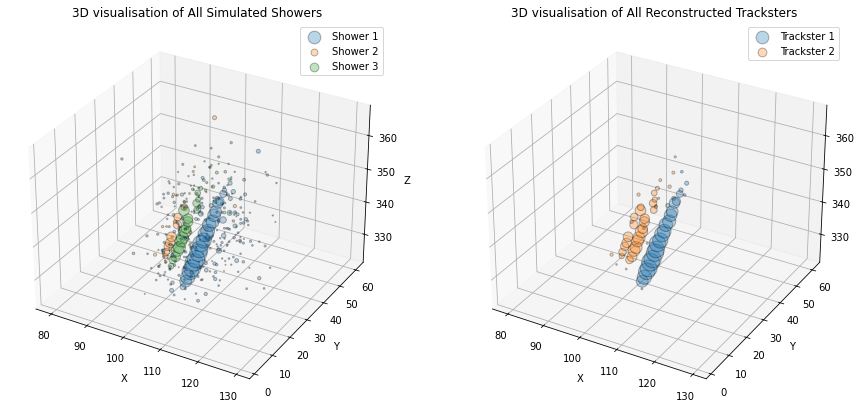

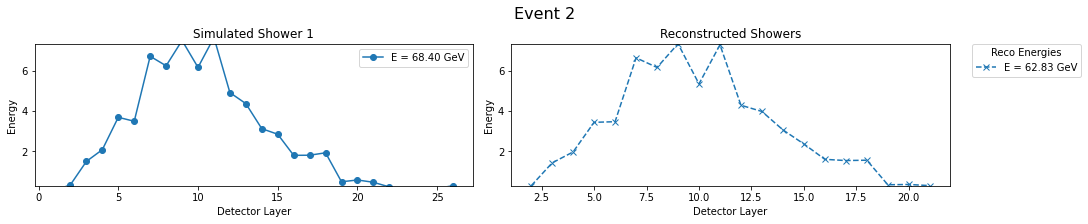

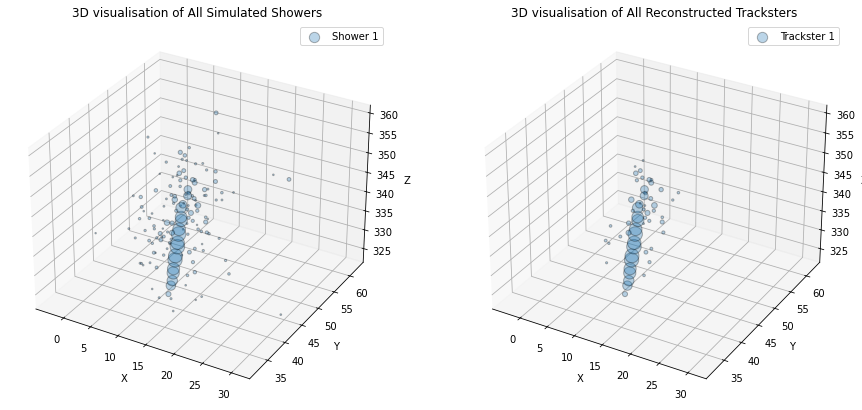

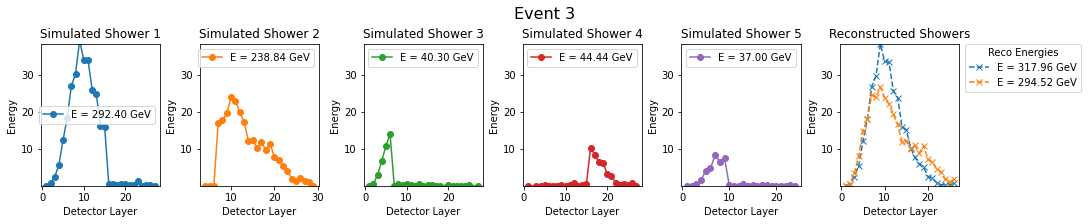

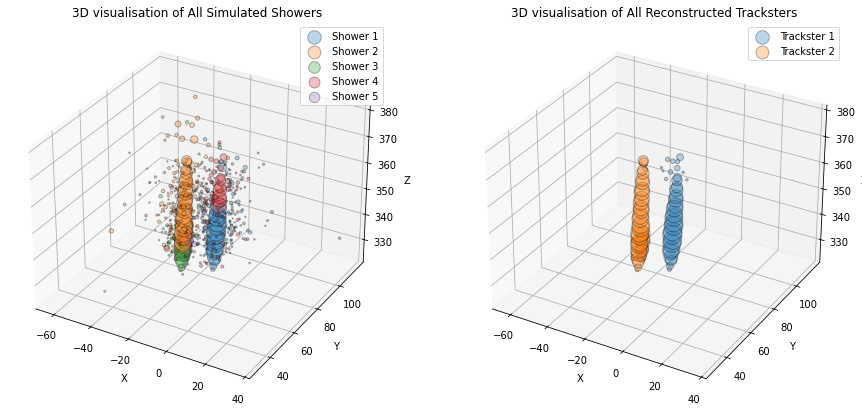

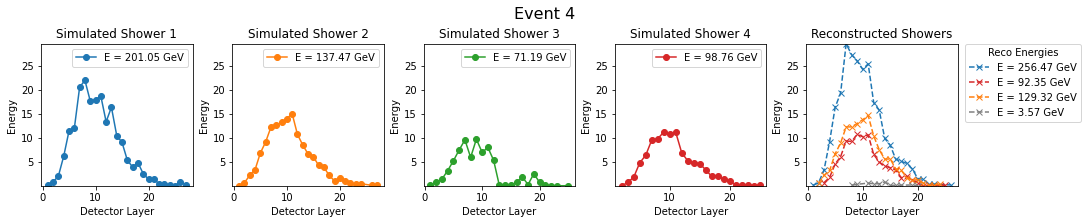

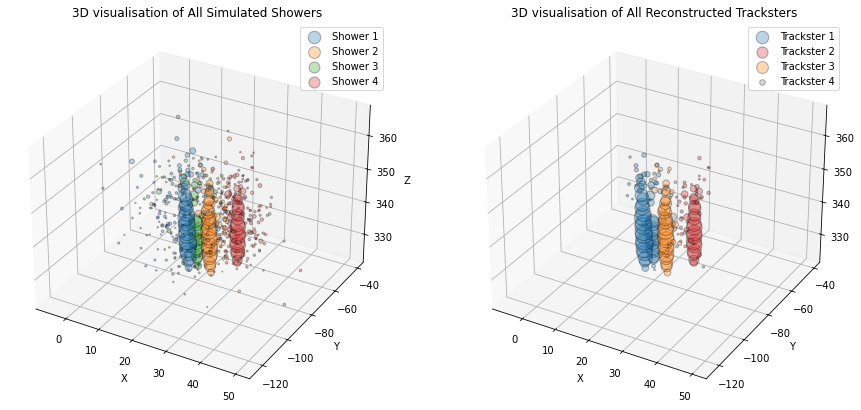

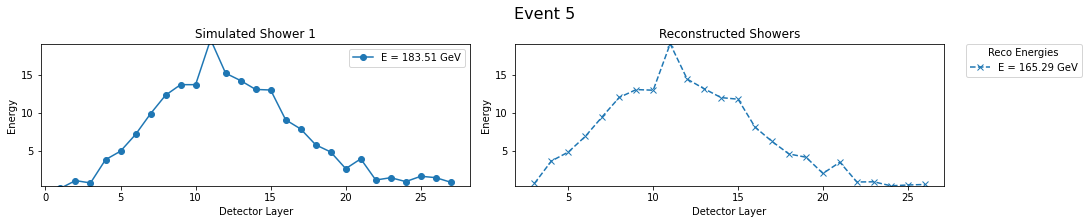

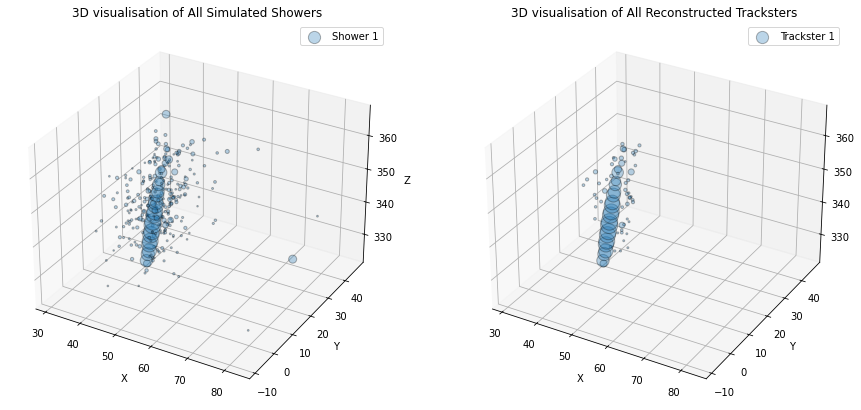

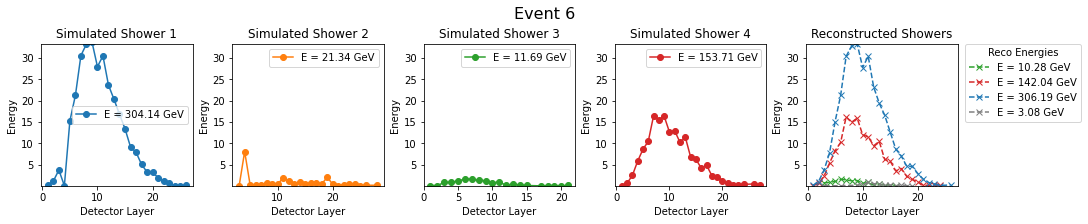

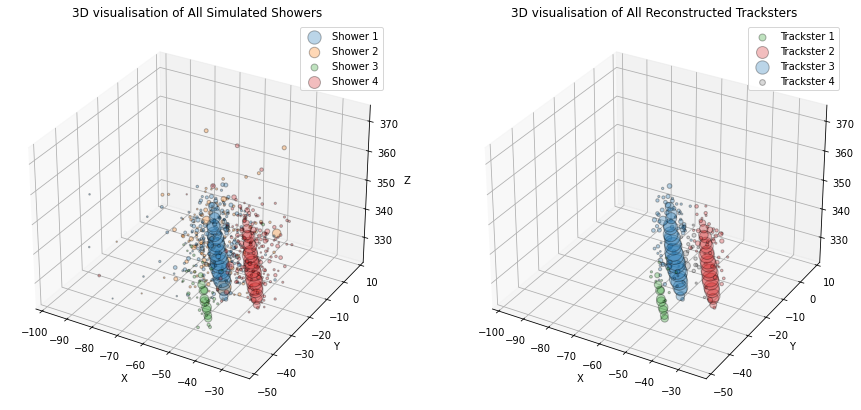

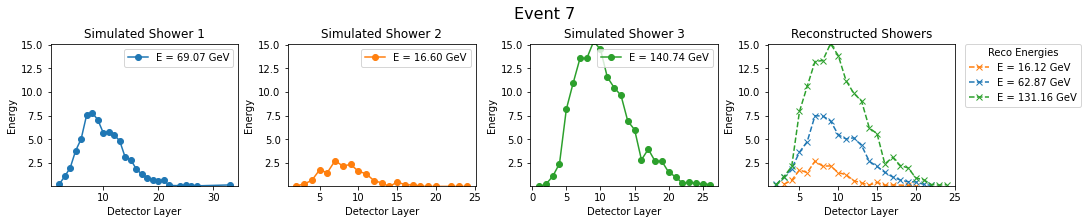

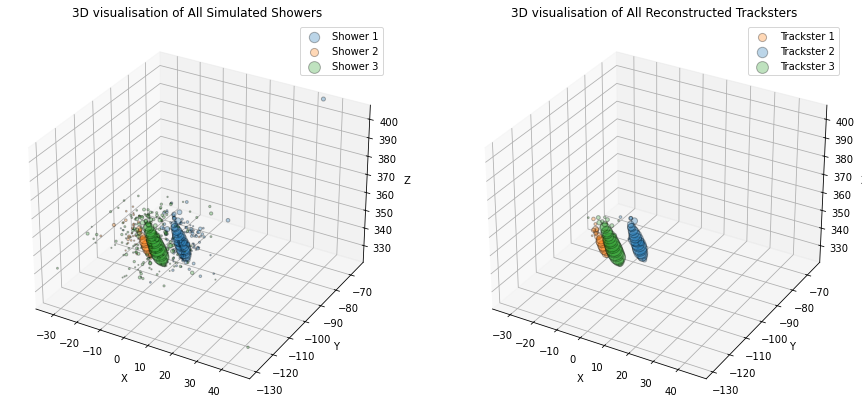

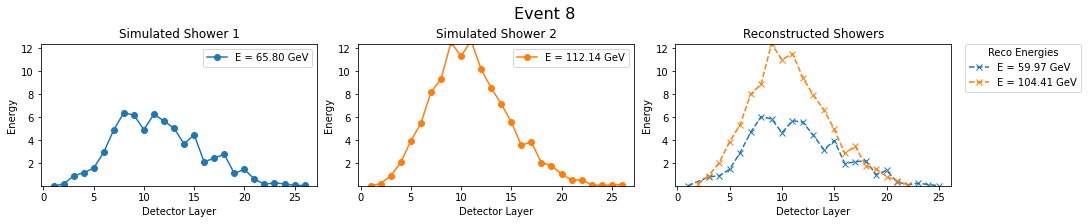

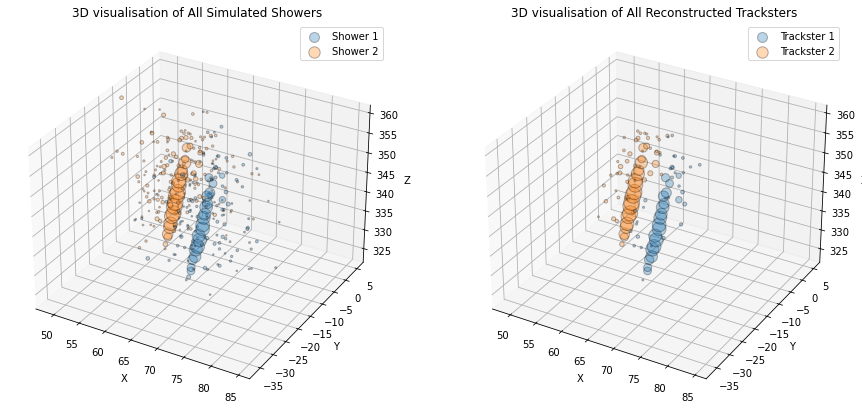

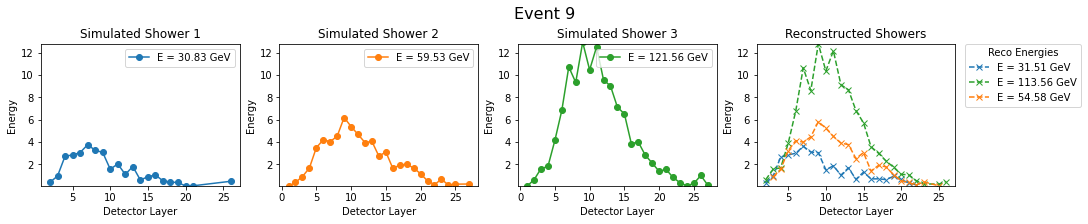

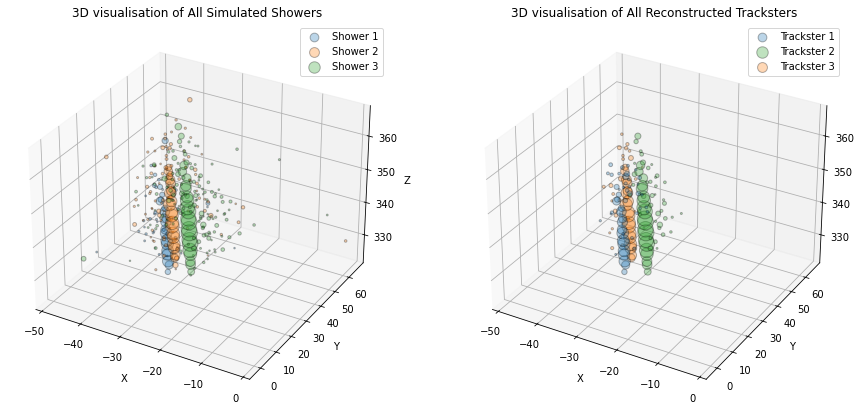

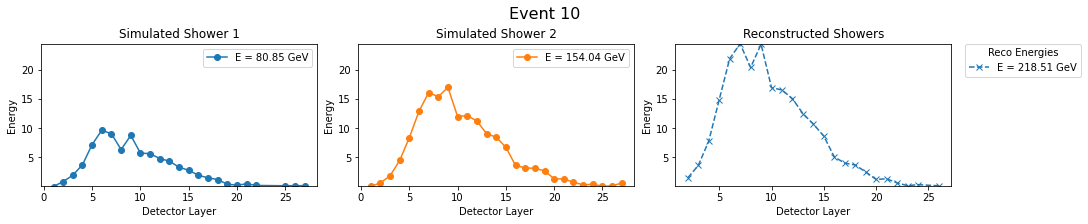

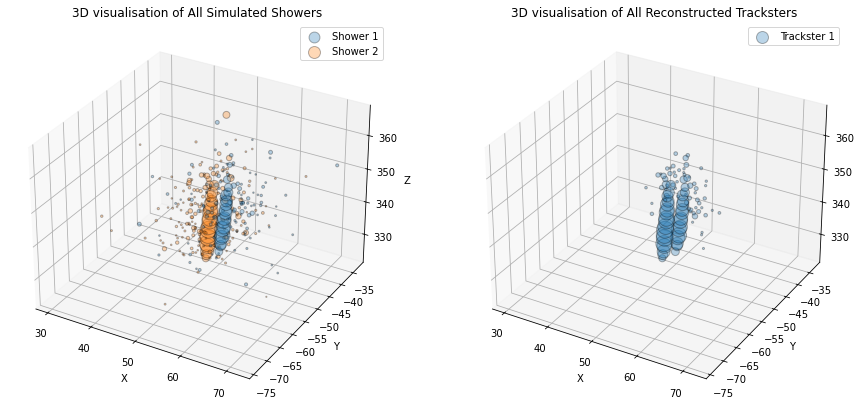

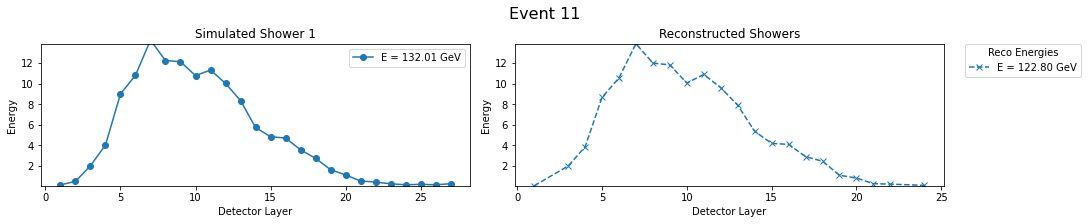

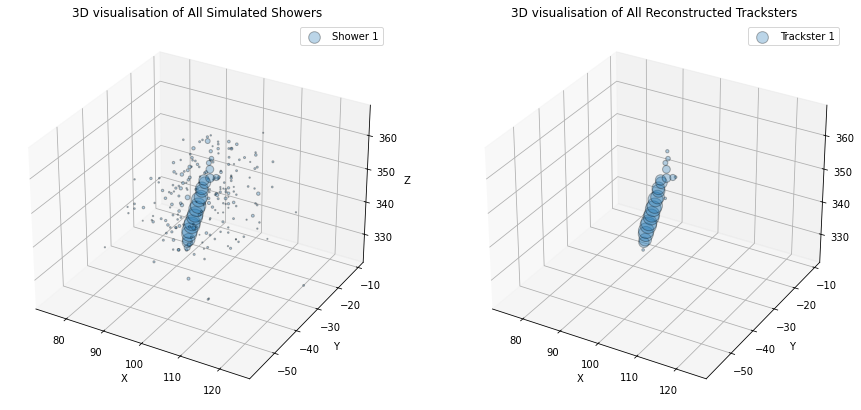

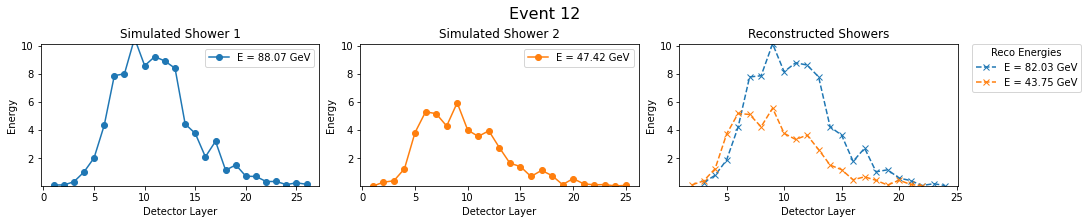

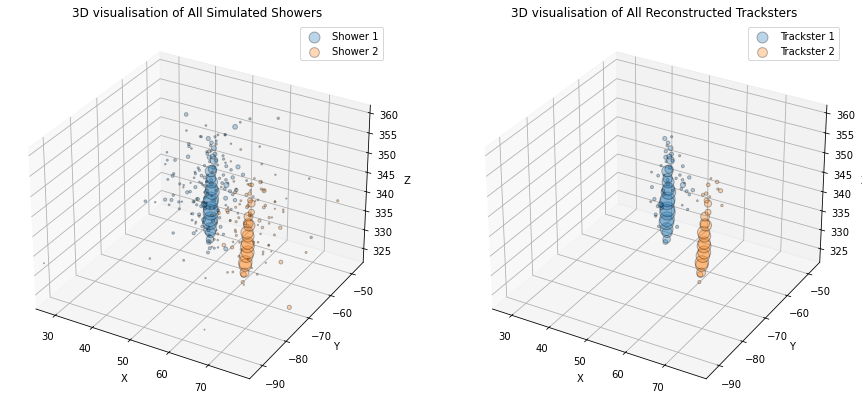

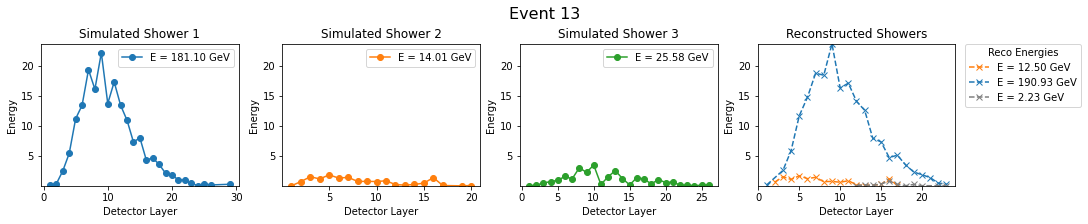

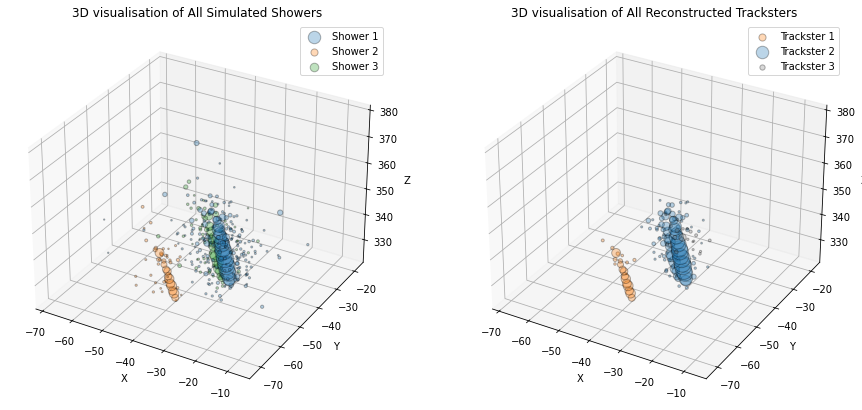

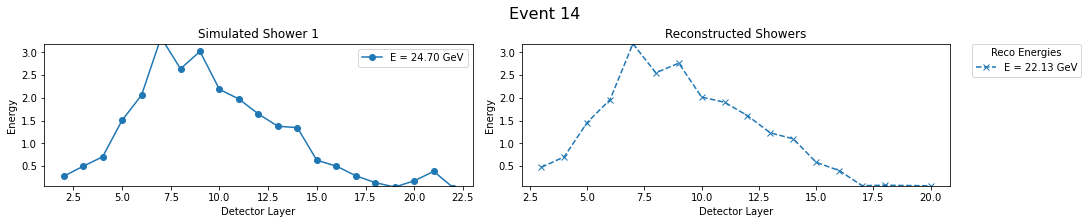

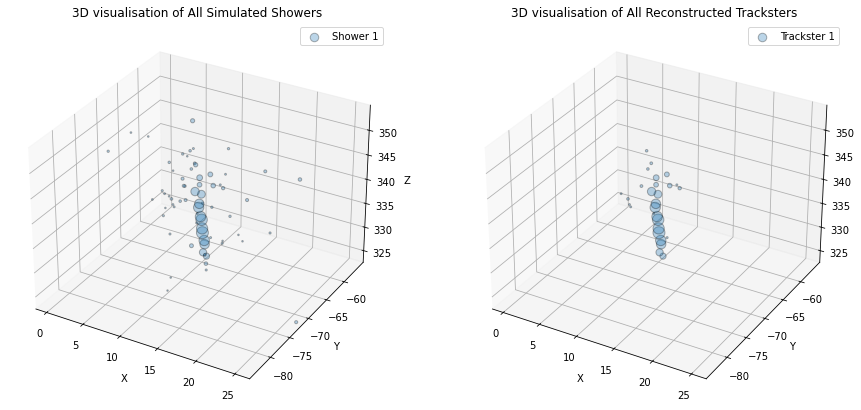

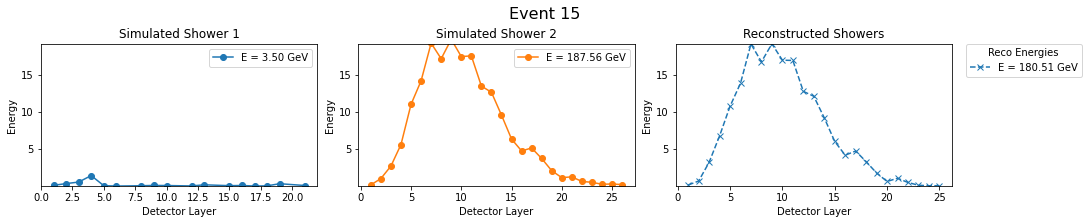

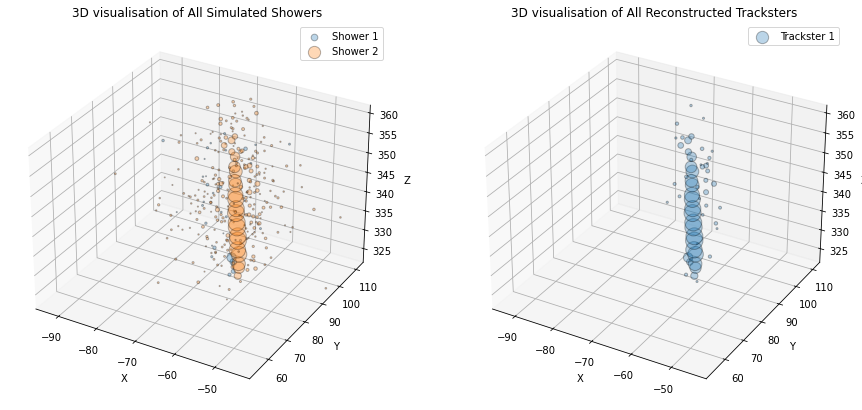

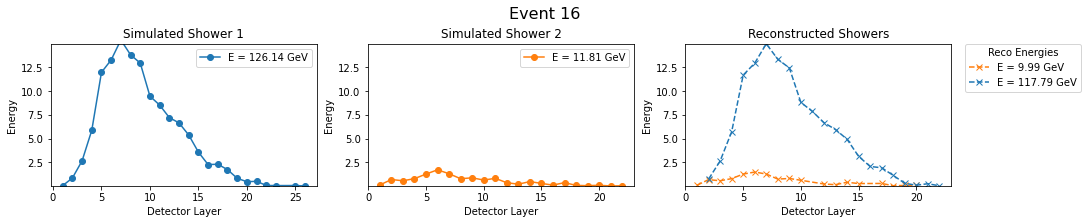

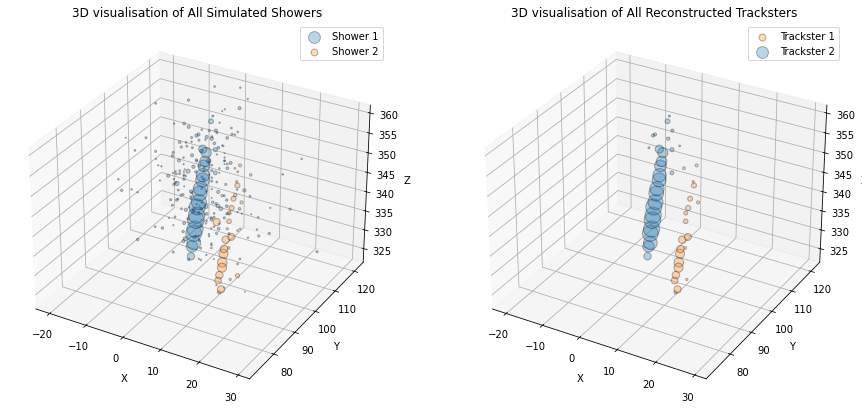

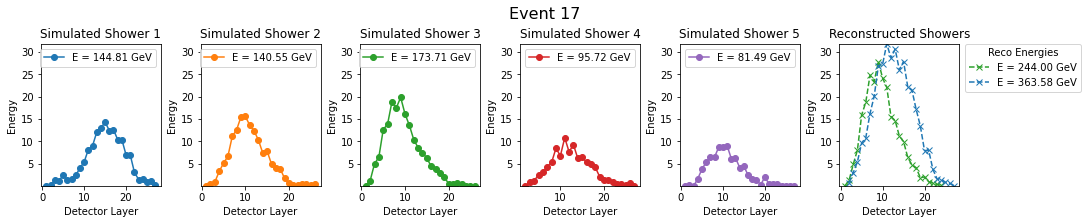

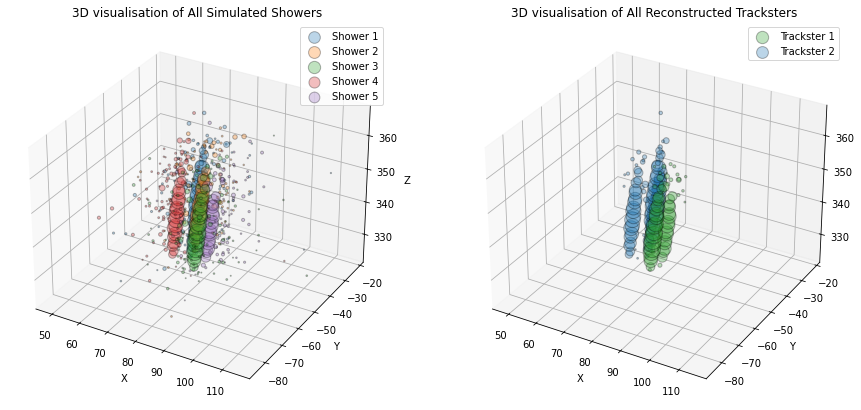

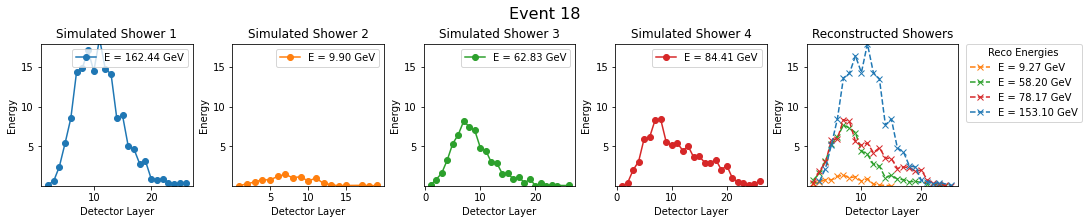

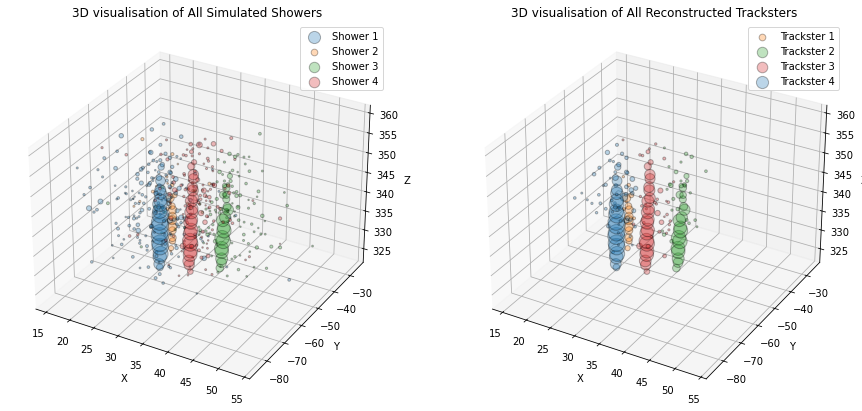

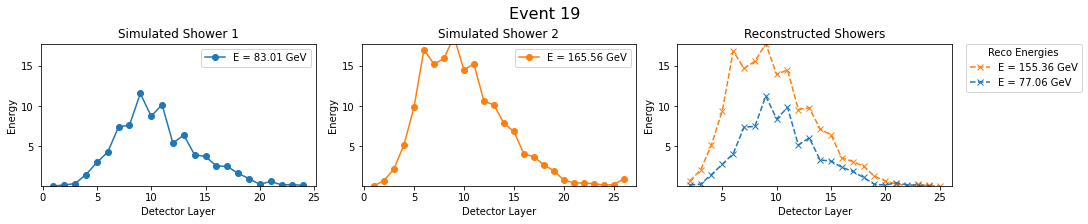

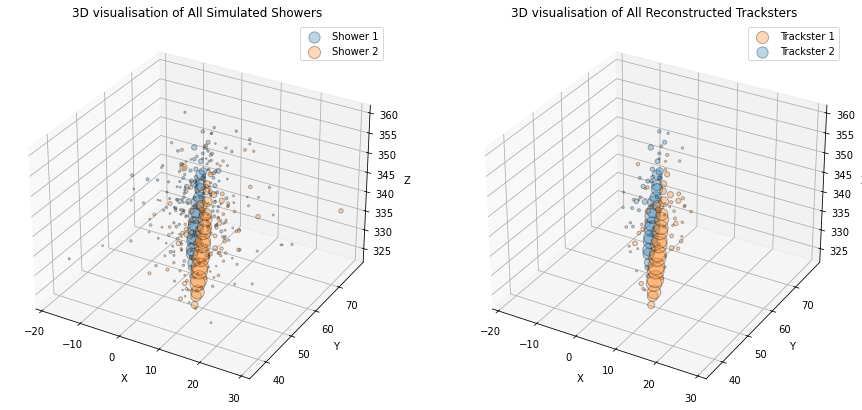

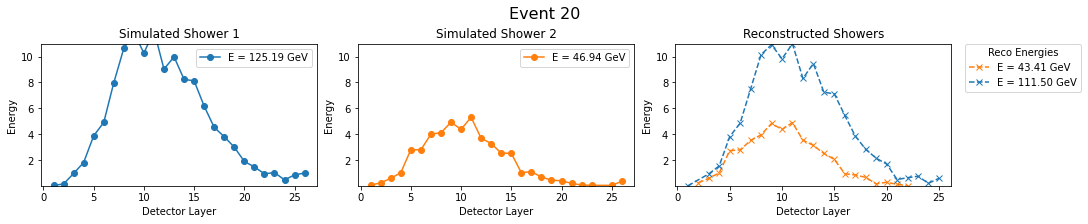

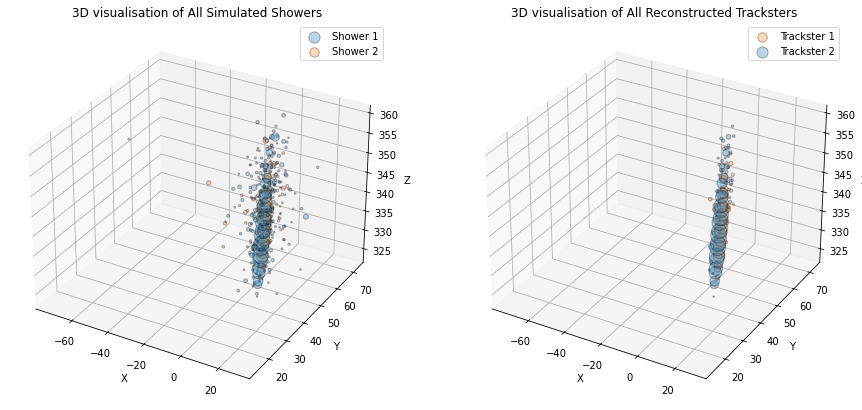

In [33]:
events = calculate_all_event_profile_data(GT_ind, energies, MT_ind_filt, layer, GT_mult)